**<font color= orange size=6> TOULOUSE Real Estate Analysis </font>**

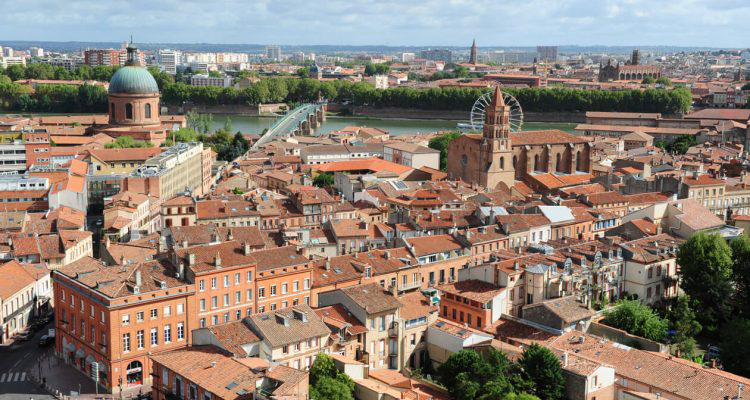

In [1]:
from PIL import Image
myImage = Image.open("toulouse.jpeg")
myImage

**<font size=5> Introduction</font>**<br>
The objective of this notebook is to **<u>analyze real estate market of the region of Toulouse</u>**. <br>
We used various graphs in order to show the different aspects of the real estate market, for example: price, area and house type. <br>
We also enriched the data by adding the population and area information to get more insights of the market. Some graphs were designed and imported from tableau as supplementeray information and to try out alternative visualisation tool. <br>
The first part of the processing is about getting a better data set i.e. cleaning and enriching. Then the analysis can start and **<font color= green>major findings</font>** from analysing the dataset are in bold green font hereafter <br>


**<font size=5>Table of Content** <br> Click to jump to each sector of the notebook
* [Dataset inspection and cleaning](#Dataset-inspection-and-cleaning)
* [Duplicates handling](#Duplicates-handling)
* [Get a glimpse of dataset](#Get-a-glimpse-of-dataset)
* [Outliers analysis](#Outliers-analysis)
* [Data cleaning](#Data-cleaning)
* [Per city analysis](#Per-city-analysis)
* [Enrich with population and area](#Enrich-with-population-and-area)
* [Compare cities across different criteria](#Compare-cities-across-different-criteria)
* [Evolution analysis](#Evolution-analysis)
* [Maps](#Maps)

In [2]:
#import packages and functions used hereafter
import pyspark
import pyspark.sql.functions as func
from pyspark.sql.functions import round, col
import pandas as pd

from pyspark.sql import Window
import pyspark.sql.functions as F
from math import pi
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

import geopandas as gpd

ModuleNotFoundError: No module named 'geopandas'

In [3]:
#sc = pyspark.SparkContext(appName="Spark-Initiation")
spark = pyspark.sql.SparkSession.builder.appName("Spark-Dataframe-SQL").getOrCreate()

In [4]:
#read excel from pandas since pyspark do not support excel
df = pd.read_excel('project_data_real_estate_toulouse_and_suburbs.xlsx', sheet_name='transactions',inferSchema='')
df.head()


SaleDate SaleType     Price  PostCode                 City  NbRooms  \
0 2019-01-15     SALE   95000.0     31270  VILLENEUVE TOLOSANE        2   
1 2019-01-21     SALE  261700.0     31270  VILLENEUVE TOLOSANE        4   
2 2019-01-03     SALE  101000.0     31270  VILLENEUVE TOLOSANE        2   
3 2019-01-11     SALE   59500.0     31270  VILLENEUVE TOLOSANE        1   
4 2019-01-15     SALE  179000.0     31270  VILLENEUVE TOLOSANE        4   

   NbLots ResidenceType  LivingArea  LandArea  
0       0         HOUSE          45       505  
1       0         HOUSE          87       311  
2       1     APARTMENT          44         0  
3       1     APARTMENT          26         0  
4       0         HOUSE          95       263

Data dictionary:
- **Sale date**: the day the property was sold <br>
- **Sale type**: 1- Sale: when the building is already constructed and ready to be sold,
                 2- Sales before completion: you buy while the building is not finished <br>
- **Price**: price of the residence in euro <br>
- **Post code**: post code of the area<br>
- **City**: name of the city <br>
- **Nb rooms**: number of rooms inside of the property<br>
- **Number of lots**: only for apartments, the number of apartments in the building <br>
- **Residence type**: two options, house or apartment<br>
- **Living area**: area of the apartment or house in m2 defined as living space (under loi carrez) <br>
- **Land area**: area of the land in m2<br>

In [5]:
#convert pandas dataframe df to pyspark dataframe sale_df
sale_df = spark.createDataFrame(df)

In [6]:
# cache dataframe since it will be used extensively
sale_df.cache()

DataFrame[SaleDate: timestamp, SaleType: string, Price: double, PostCode: bigint, City: string, NbRooms: bigint, NbLots: bigint, ResidenceType: string, LivingArea: bigint, LandArea: bigint]

In [7]:
# delete panda data frame to free up RAM since it's huge
del(df)

# <span style="color:black">Dataset inspection and cleaning

In [8]:
# see how many lines in the dataset
print("data frame has",sale_df.count(), "lines i.e. ",sale_df.count(), "total sales")

data frame has 80118 lines i.e.  80118 total sales


In [9]:
# inspect the first 2 lines
sale_df.show(n=2)

+-------------------+--------+--------+--------+-------------------+-------+------+-------------+----------+--------+
|           SaleDate|SaleType|   Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+-------------------+--------+--------+--------+-------------------+-------+------+-------------+----------+--------+
|2019-01-15 00:00:00|    SALE| 95000.0|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|
|2019-01-21 00:00:00|    SALE|261700.0|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|
+-------------------+--------+--------+--------+-------------------+-------+------+-------------+----------+--------+
only showing top 2 rows



In [10]:
# get column names
sale_df.schema.names

['SaleDate',
 'SaleType',
 'Price',
 'PostCode',
 'City',
 'NbRooms',
 'NbLots',
 'ResidenceType',
 'LivingArea',
 'LandArea']

In [11]:
# get the entire schema
sale_df.printSchema()

root
 |-- SaleDate: timestamp (nullable = true)
 |-- SaleType: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- PostCode: long (nullable = true)
 |-- City: string (nullable = true)
 |-- NbRooms: long (nullable = true)
 |-- NbLots: long (nullable = true)
 |-- ResidenceType: string (nullable = true)
 |-- LivingArea: long (nullable = true)
 |-- LandArea: long (nullable = true)



## Duplicates handling

In [12]:
N_duplicate = sale_df.count() - sale_df.distinct().count()
print("There are ", N_duplicate, " similar lines, which is not expected so require further investigation")

There are  8162  similar lines, which is not expected so require further investigation


In [13]:
# inspect 10 duplicates to see if they look normal or suspicious
df_dup=sale_df.groupBy("SaleDate","SaleType","Price","PostCode","City","NbRooms","NbLots","ResidenceType","LivingArea","LandArea").count().filter('count > 1')
df_dup.show(n=10)


+-------------------+--------------------+-----------+--------+--------------------+-------+------+-------------+----------+--------+-----+
|           SaleDate|            SaleType|      Price|PostCode|                City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|count|
+-------------------+--------------------+-----------+--------+--------------------+-------+------+-------------+----------+--------+-----+
|2018-01-11 00:00:00|                SALE|   480000.0|   31000|            TOULOUSE|      1|     0|    APARTMENT|        40|      84|    2|
|2017-12-18 00:00:00|                SALE|     1.16E7|   31100|            TOULOUSE|      4|     0|    APARTMENT|        80|    2000|   12|
|2015-04-08 00:00:00|                SALE|2.2388534E7|   31100|            TOULOUSE|      3|     0|        HOUSE|        65|    3783|    9|
|2017-07-13 00:00:00|                SALE|  1700000.0|   31520|RAMONVILLE-SAINT-...|      3|     0|    APARTMENT|        68|    1392|    7|
|2015-09-30 00:00:00

It's strange to have 3 or 4 duplicates of the exact same sales. But they are appartments so still possible. <br>
We want to see that there are house duplicates which would be highly suspicious

In [14]:
df_dup.select("ResidenceType").distinct().show()

+-------------+
|ResidenceType|
+-------------+
|        HOUSE|
|    APARTMENT|
+-------------+



since there are also houses we now **assume all duplicates are wrong (corrupted data) so remove them**

In [15]:
# drop duplicates
sale_df = sale_df.dropDuplicates()

## Get a glimpse of dataset

In [16]:
# get a glimpse of the data frame essential metrics
df_summary = sale_df.summary()
df_summary.show()

+-------+--------------------+------------------+------------------+-------------------+------------------+------------------+-------------+-----------------+------------------+
|summary|            SaleType|             Price|          PostCode|               City|           NbRooms|            NbLots|ResidenceType|       LivingArea|          LandArea|
+-------+--------------------+------------------+------------------+-------------------+------------------+------------------+-------------+-----------------+------------------+
|  count|               71956|             71956|             71956|              71956|             71956|             71956|        71956|            71956|             71956|
|   mean|                null|347623.66188017675|31321.185724609484|               null|  3.03214464394908|1.0567569069987215|         null|67.93580799377398|177.05571460336873|
| stddev|                null|1402593.3753334822|222.06402647189978|               null|1.3686111105346523|0.8

In [17]:
# previous  display was messy so show only 6 first columns to see it neatly
# pick and choose and round
df_summary.select(col("summary"), 
                  col("SaleType"), 
                  func.round(df_summary["Price"],0).alias("Price rounded"), 
                  func.round(df_summary["PostCode"],0).alias("PostCode"), 
                  col("City")
                 ).show()

+-------+--------------------+-------------+--------+-------------------+
|summary|            SaleType|Price rounded|PostCode|               City|
+-------+--------------------+-------------+--------+-------------------+
|  count|               71956|      71956.0| 71956.0|              71956|
|   mean|                null|     347624.0| 31321.0|               null|
| stddev|                null|    1402593.0|   222.0|               null|
|    min|                SALE|          0.0| 31000.0|         AUCAMVILLE|
|    25%|                null|     120000.0| 31170.0|               null|
|    50%|                null|     177310.0| 31300.0|               null|
|    75%|                null|     267950.0| 31500.0|               null|
|    max|SALE BEFORE COMPL...|  3.3427218E7| 31830.0|VILLENEUVE TOLOSANE|
+-------+--------------------+-------------+--------+-------------------+



Price look strange, standard deviations and max look huged compared to mean, it **suggests lots of outliers possibly wrong data**

In [18]:
# display the remaining columns
df_summary.select(col("summary"),
                  func.round(df_summary["NbRooms"],2).alias("NbRooms"),  
                  func.round(df_summary["NbLots"],2).alias("NbLots"), 
                  col("ResidenceType"),
                  func.round(df_summary["LivingArea"],1).alias("LivingArea"), 
                  func.round(df_summary["LandArea"],0).alias("LandArea"), 
                 ).show()


+-------+-------+-------+-------------+----------+--------+
|summary|NbRooms| NbLots|ResidenceType|LivingArea|LandArea|
+-------+-------+-------+-------------+----------+--------+
|  count|71956.0|71956.0|        71956|   71956.0| 71956.0|
|   mean|   3.03|   1.06|         null|      67.9|   177.0|
| stddev|   1.37|   0.82|         null|      36.7|  1175.0|
|    min|    1.0|    0.0|    APARTMENT|       1.0|     0.0|
|    25%|    2.0|    1.0|         null|      43.0|     0.0|
|    50%|    3.0|    1.0|         null|      62.0|     0.0|
|    75%|    4.0|    2.0|         null|      83.0|     0.0|
|    max|   41.0|   13.0|        HOUSE|     481.0| 60792.0|
+-------+-------+-------+-------------+----------+--------+



There are more suspicious data here: max NbRooms (41), min LivingArea (1m2), max LandArea (60792m2) <br>
We'll need to take a closer look at that to see if additional data should be discarded

## Outliers analysis

### Price 

we will do a box plot of prices for all cities to get a feel of data distribution and outliers

[Text(0, 0, 'VILLENEUVE TOLOSANE'),
 Text(0, 0, 'VIEILLE TOULOUSE'),
 Text(0, 0, 'TOURNEFEUILLE'),
 Text(0, 0, 'TOULOUSE'),
 Text(0, 0, 'QUINT-FONSEGRIVES'),
 Text(0, 0, 'SAINT-ORENS-DE-GAMEVILLE'),
 Text(0, 0, 'SAINT-JEAN'),
 Text(0, 0, 'RAMONVILLE-SAINT-AGNE'),
 Text(0, 0, 'PORTET SUR GARONNE'),
 Text(0, 0, 'PLAISANCE DU TOUCH'),
 Text(0, 0, 'PIBRAC'),
 Text(0, 0, 'MURET'),
 Text(0, 0, 'LEGUEVIN'),
 Text(0, 0, 'LABEGE'),
 Text(0, 0, 'L UNION'),
 Text(0, 0, 'FENOUILLET'),
 Text(0, 0, 'ESCALQUENS'),
 Text(0, 0, 'CUGNAUX'),
 Text(0, 0, 'CORNEBARRIEU'),
 Text(0, 0, 'COLOMIERS'),
 Text(0, 0, 'CASTANET TOLOSAN'),
 Text(0, 0, 'BLAGNAC'),
 Text(0, 0, 'BEAUZELLE'),
 Text(0, 0, 'BALMA'),
 Text(0, 0, 'AUZEVILLE-TOLOSANE'),
 Text(0, 0, 'AUCAMVILLE')]

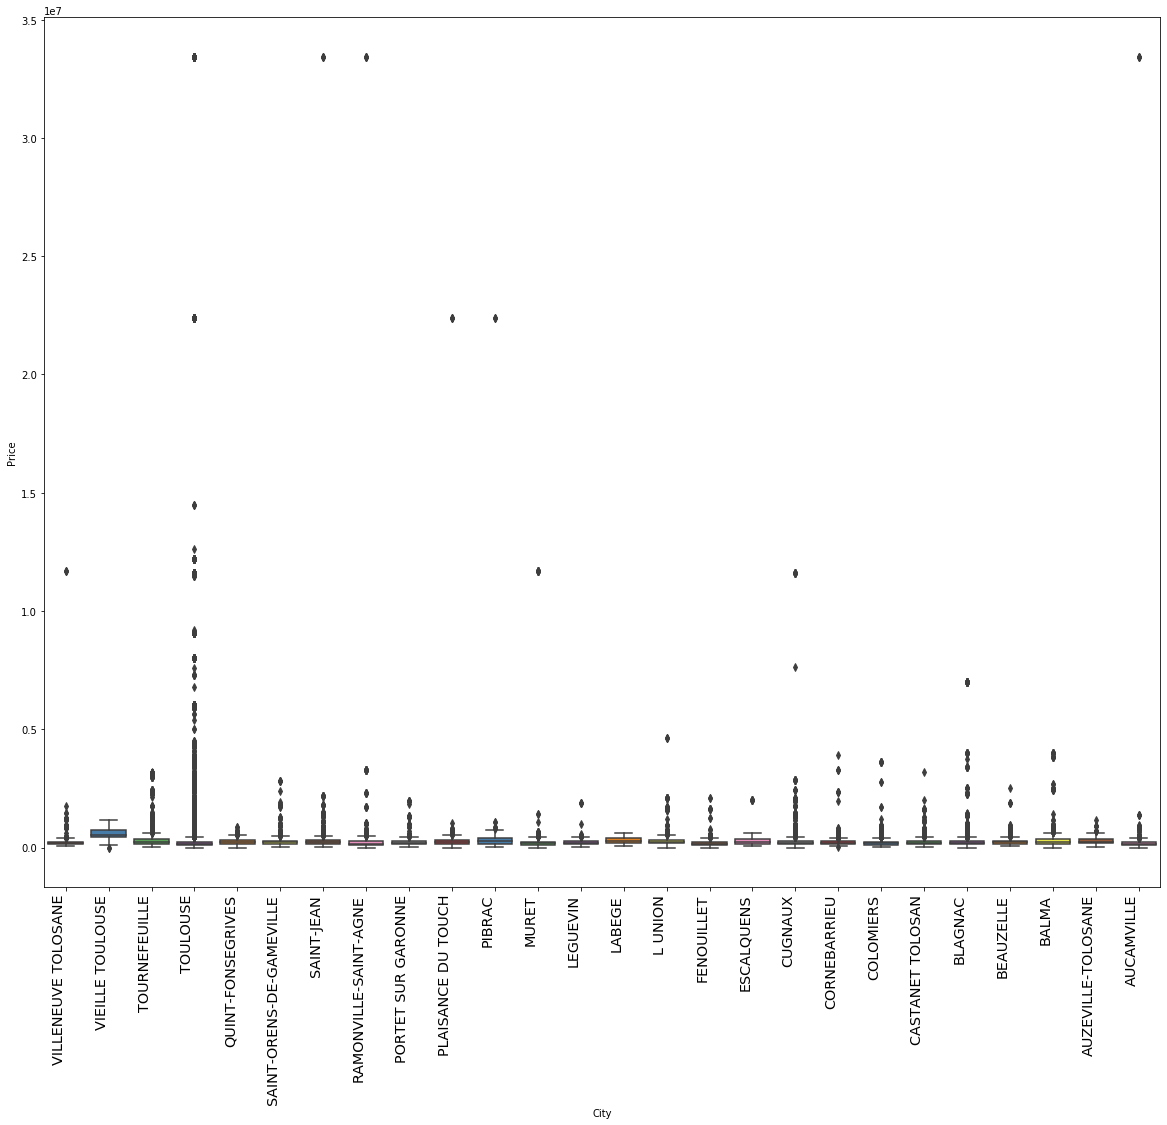

In [19]:
# convert to pandas and plot
pd_df = sale_df.toPandas()
# convert to float
pd_df['Price'] = pd_df['Price'].astype(float)

plt.figure( figsize = (20, 16) )
chart=sb.boxplot(x="City", y="Price", data=pd_df, palette="Set1")
chart.set_xticklabels(
                        chart.get_xticklabels(), 
                        rotation=90, 
                        horizontalalignment='right',
                        fontweight='light',
                        fontsize='x-large',
                    )

remove sales above 5 millions euros and below 10k euros, they are as assumed either wrong entries or irrelevant

In [20]:
#number of samples before cleaning
N      = len(pd_df)
pd_df  = pd_df[(pd_df.Price < 5e6) & (pd_df.Price > 10e3)]
print(N-len(pd_df), "outliers samples removed")

643 outliers samples removed


box plot with all data was too strechout out to be able to clearly see dataset distribution, see now after cleaning

[Text(0, 0, 'VILLENEUVE TOLOSANE'),
 Text(0, 0, 'VIEILLE TOULOUSE'),
 Text(0, 0, 'TOURNEFEUILLE'),
 Text(0, 0, 'TOULOUSE'),
 Text(0, 0, 'QUINT-FONSEGRIVES'),
 Text(0, 0, 'SAINT-ORENS-DE-GAMEVILLE'),
 Text(0, 0, 'SAINT-JEAN'),
 Text(0, 0, 'RAMONVILLE-SAINT-AGNE'),
 Text(0, 0, 'PORTET SUR GARONNE'),
 Text(0, 0, 'PLAISANCE DU TOUCH'),
 Text(0, 0, 'PIBRAC'),
 Text(0, 0, 'MURET'),
 Text(0, 0, 'LEGUEVIN'),
 Text(0, 0, 'LABEGE'),
 Text(0, 0, 'L UNION'),
 Text(0, 0, 'FENOUILLET'),
 Text(0, 0, 'ESCALQUENS'),
 Text(0, 0, 'CUGNAUX'),
 Text(0, 0, 'CORNEBARRIEU'),
 Text(0, 0, 'COLOMIERS'),
 Text(0, 0, 'CASTANET TOLOSAN'),
 Text(0, 0, 'BLAGNAC'),
 Text(0, 0, 'BEAUZELLE'),
 Text(0, 0, 'BALMA'),
 Text(0, 0, 'AUZEVILLE-TOLOSANE'),
 Text(0, 0, 'AUCAMVILLE')]

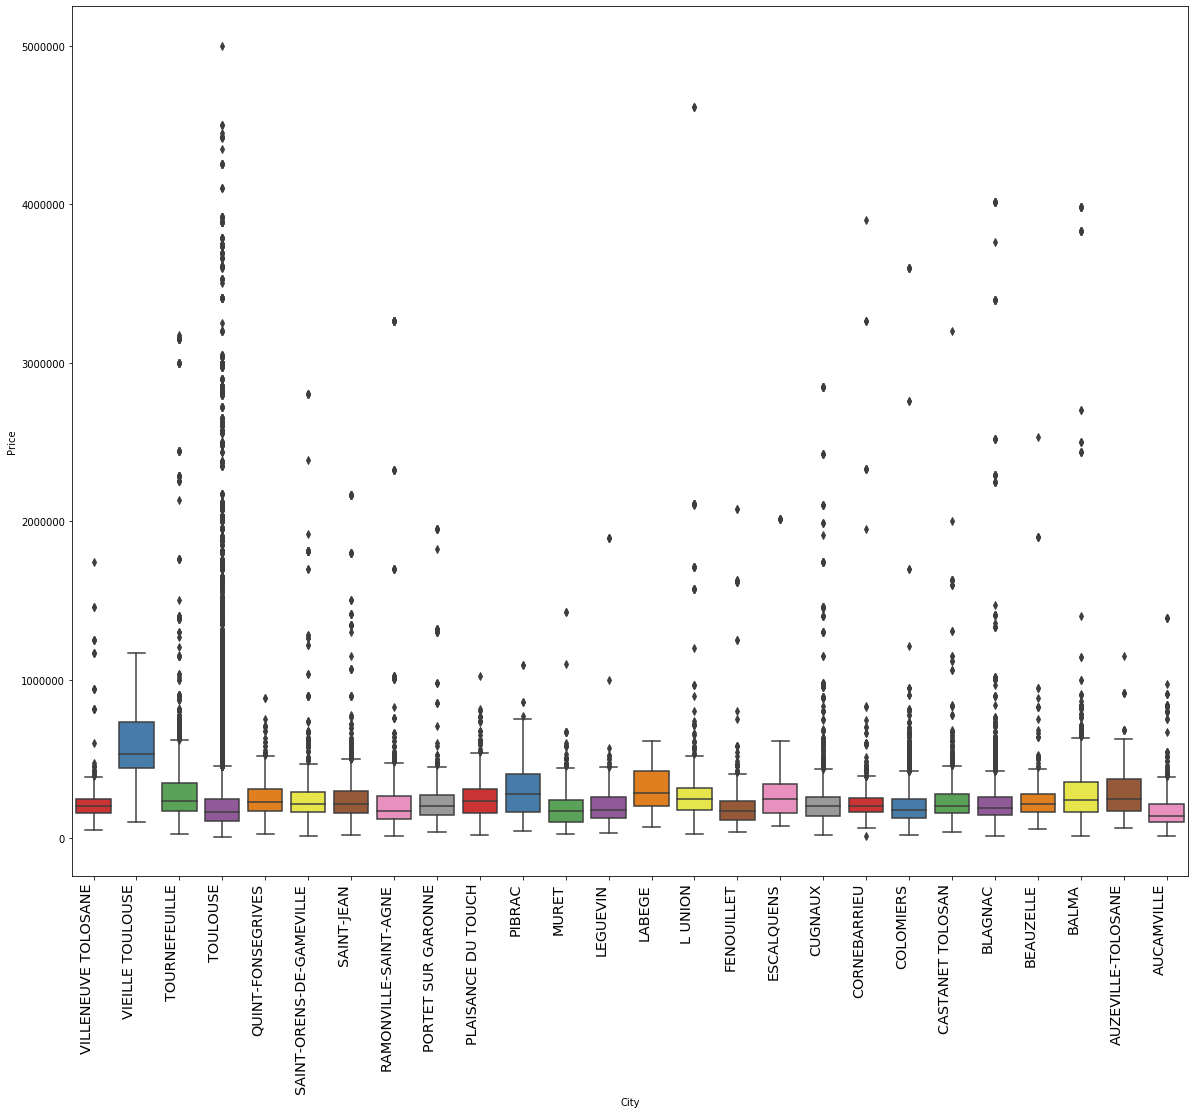

In [21]:
ax = plt.figure( figsize = (20, 16) )
chart=sb.boxplot(x="City", y="Price", data=pd_df, palette="Set1")
chart.set_xticklabels(
                        chart.get_xticklabels(), 
                        rotation=90, 
                        horizontalalignment='right',
                        fontweight='light',
                        fontsize='x-large',
                    )


previous boxplot gives a feel of global data distribution but for a finer analysis we need to zoom in to focus on the quartiles and factor out outliers. Also it's good to seperate HOUSE and APPARTMENT since they have different distributions

(0, 800000.0)

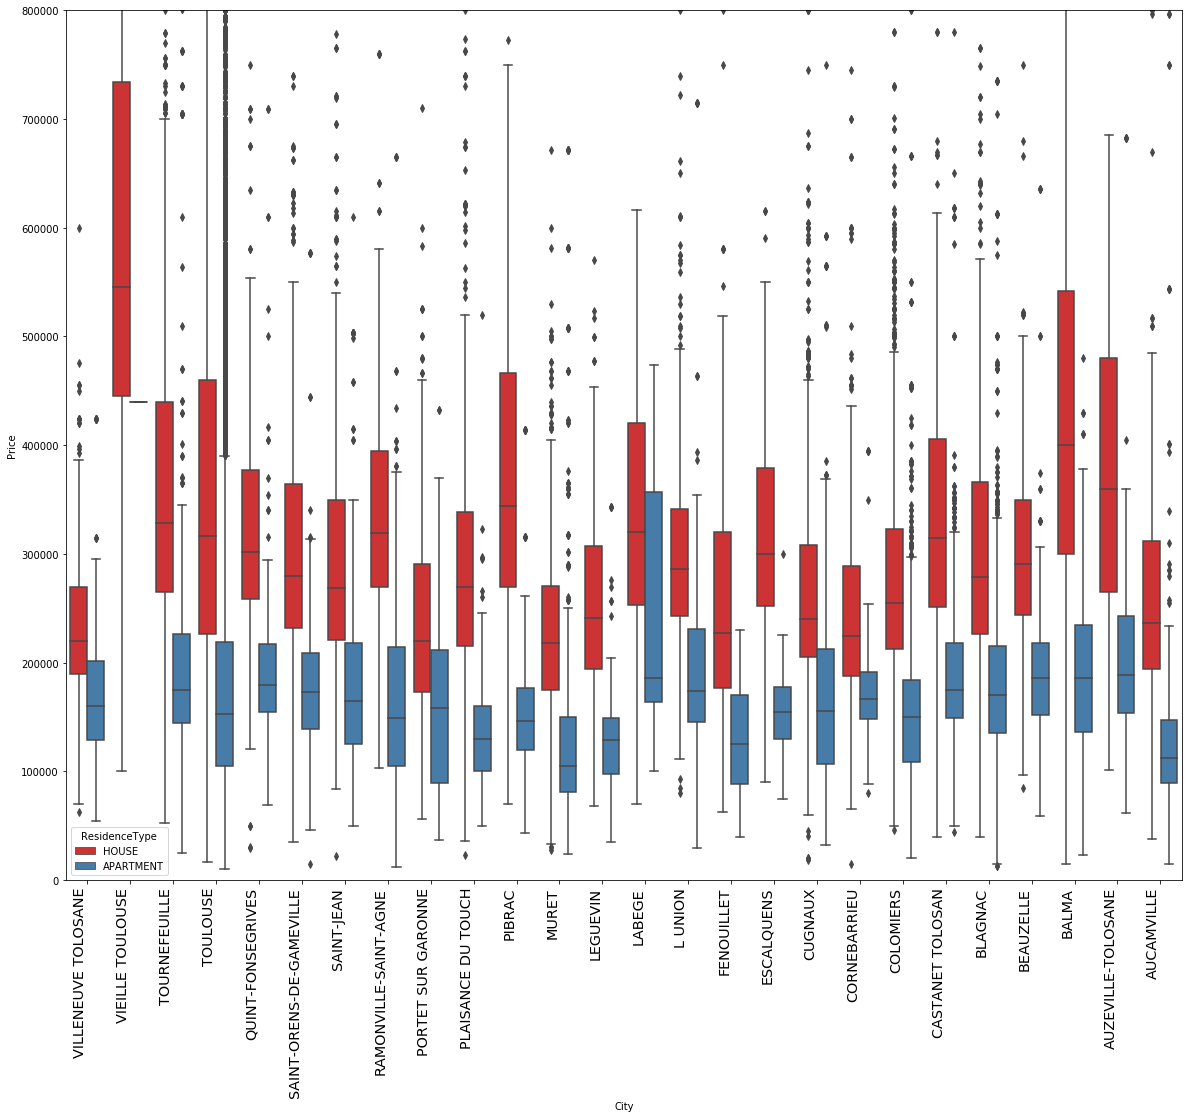

In [22]:
ax = plt.figure( figsize = (20, 16) )
chart=sb.boxplot(x="City", y="Price", hue="ResidenceType", data=pd_df, palette="Set1")
chart.set_xticklabels(
                        chart.get_xticklabels(), 
                        rotation=90, 
                        horizontalalignment='right',
                        fontweight='light',
                        fontsize='x-large',
                    )

plt.ylim(0, 0.8e6)

box plots are very nice to see quartiles and outliers and range but we don't see actual distribution shape. For that we use <a href="https://python-graph-gallery.com/violin-plot/">violin plots</a>

(0, 800000.0)

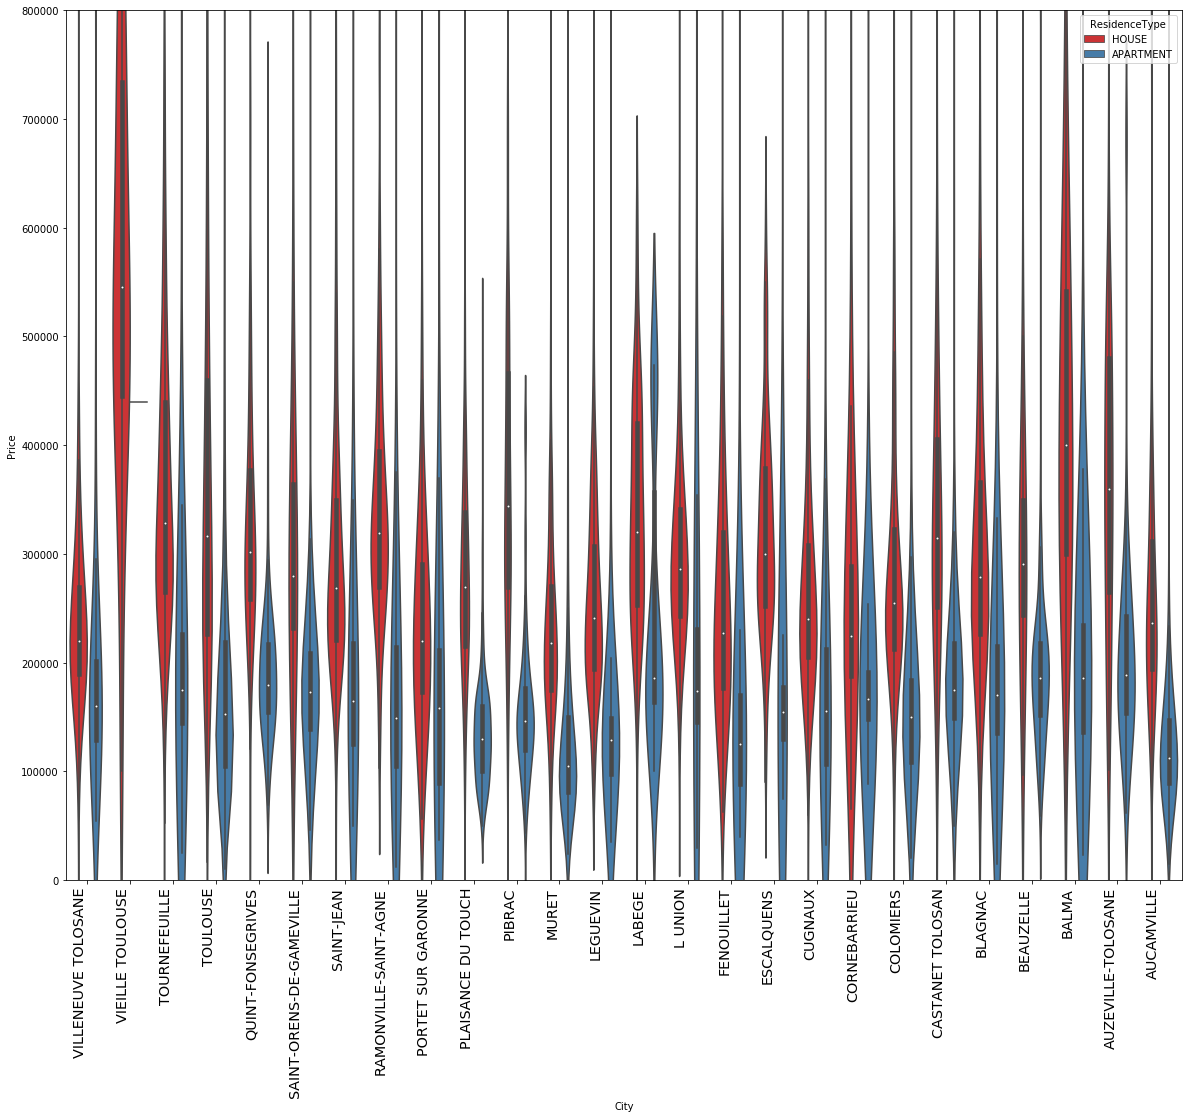

In [23]:
ax = plt.figure( figsize = (20, 16) )
chart=sb.violinplot(x="City", y="Price", hue="ResidenceType", data=pd_df, palette="Set1")
chart.set_xticklabels(
                        chart.get_xticklabels(), 
                        rotation=90, 
                        horizontalalignment='right',
                        fontweight='light',
                        fontsize='x-large',
                    )

plt.ylim(0, 0.8e6)

it appears that the distribution follows a standard gaussian curve more or less streched i.e. standard deviation will be different per city

In [24]:
# remove now this panda dataframe since it's huge and was temporary
del(pd_df)

## Data cleaning

we have inspect data and will now clean data set dropping duplicates and suspicious data <br>
duplicates were already dropped in pyspark dataframe sale_df <br>
we'll now **remove suspicious data
* **remove any price above 5 millions and below 10 thousand**
* **remove any number of room above 15**
* **remove any area below 10m2**

In [25]:
sale_df1 = sale_df.select('*').filter('Price < 5e6')\
                              .filter('Price > 1e3')\
                              .filter('NbRooms < 15')\
                              .filter('LivingArea > 10')


In [26]:
print(sale_df.count()-sale_df1.count(), "samples were removed")

592 samples were removed


# Per city analysis

In [27]:
print("there are",sale_df1.select("City").distinct().count(), "cities in the dataset")

there are 26 cities in the dataset


convert to pandas dataframe at that point because dataframes are small enough after processong and the merge will be way simpler in pandas

## Process data in pyspark

compute mean values for rooms, living area and land area. <br>
for price we have seen many outliers and very streched values so quartiles will be way more meaningful and interpretable than mean

In [28]:
#price_pd_df      = sale_df1.groupBy('City','ResidenceType').agg({'price':'avg'}).withColumnRenamed('avg(price)','mean_price').orderBy(['City','ResidenceType'], ascending=[True, True]).toPandas()
NbRooms_pd_df    = sale_df1.groupBy('City','ResidenceType').agg({'NbRooms':'avg'}).withColumnRenamed('avg(NbRooms)','mean_NbRooms').orderBy(['City','ResidenceType'], ascending=[True, True]).toPandas()
LivingArea_pd_df = sale_df1.groupBy('City','ResidenceType').agg({'LivingArea':'avg'}).withColumnRenamed('avg(LivingArea)','LivingArea').orderBy(['City','ResidenceType'], ascending=[True, True]).toPandas()
LandArea_pd_df   = sale_df1.groupBy('City','ResidenceType').agg({'LandArea':'avg'}).withColumnRenamed('avg(LandArea)','LandArea').orderBy(['City','ResidenceType'], ascending=[True, True]).toPandas()

magic_percentile = F.expr('percentile_approx(Price, array(0.25, 0.5, 0.75))')
quartile_price_df= sale_df1.groupBy(['City', "ResidenceType"]).agg(magic_percentile.alias('Q1_Q2_Q3 price')).orderBy(['City','ResidenceType'], ascending=[True, True]).toPandas()


print dataframes to check the order is the same accross dataframes which should be the case since they were ordered so

In [29]:
#print(price_pd_df) 
print(NbRooms_pd_df)
print(LivingArea_pd_df)
print(LivingArea_pd_df)
print(quartile_price_df)


                        City ResidenceType  mean_NbRooms
0                 AUCAMVILLE     APARTMENT      2.529412
1                 AUCAMVILLE         HOUSE      4.158228
2         AUZEVILLE-TOLOSANE     APARTMENT      3.038462
3         AUZEVILLE-TOLOSANE         HOUSE      5.029703
4                      BALMA     APARTMENT      2.935484
5                      BALMA         HOUSE      5.087287
6                  BEAUZELLE     APARTMENT      2.795918
7                  BEAUZELLE         HOUSE      4.463918
8                    BLAGNAC     APARTMENT      2.732633
9                    BLAGNAC         HOUSE      4.303390
10          CASTANET TOLOSAN     APARTMENT      2.673143
11          CASTANET TOLOSAN         HOUSE      4.721713
12                 COLOMIERS     APARTMENT      2.816459
13                 COLOMIERS         HOUSE      4.543611
14              CORNEBARRIEU     APARTMENT      2.629310
15              CORNEBARRIEU         HOUSE      4.101523
16                   CUGNAUX   

drop duplicated columns before concatenation

In [30]:
#NbRooms_pd_df.drop(columns=['City','ResidenceType'],inplace=True)
LivingArea_pd_df.drop(columns=['City','ResidenceType'],inplace=True)
LandArea_pd_df.drop(columns=['City','ResidenceType'],inplace=True)
quartile_price_df.drop(columns=['City','ResidenceType'],inplace=True)

df1 = pd.concat([NbRooms_pd_df,LivingArea_pd_df,LandArea_pd_df,quartile_price_df], axis=1)
df1

City ResidenceType  mean_NbRooms  LivingArea  \
0                 AUCAMVILLE     APARTMENT      2.529412   53.206677   
1                 AUCAMVILLE         HOUSE      4.158228   96.962025   
2         AUZEVILLE-TOLOSANE     APARTMENT      3.038462   66.067308   
3         AUZEVILLE-TOLOSANE         HOUSE      5.029703  131.811881   
4                      BALMA     APARTMENT      2.935484   63.025090   
5                      BALMA         HOUSE      5.087287  130.277040   
6                  BEAUZELLE     APARTMENT      2.795918   59.209184   
7                  BEAUZELLE         HOUSE      4.463918  102.556701   
8                    BLAGNAC     APARTMENT      2.732633   58.763573   
9                    BLAGNAC         HOUSE      4.303390   98.715254   
10          CASTANET TOLOSAN     APARTMENT      2.673143   58.518857   
11          CASTANET TOLOSAN         HOUSE      4.721713  117.391437   
12                 COLOMIERS     APARTMENT      2.816459   60.000592   
13                 COLOMIERS         HOUSE      4.543611  104.812373   
14              CORNEBARRIEU     APARTMENT      2.629310   56.612069   
15              CORNEBARRIEU         HOUSE      4.101523   99.225888   
16                   CUGNAUX     APARTMENT      2.741870   58.078252   
17                   CUGNAUX         HOUSE      4.227931   99.561265   
18                ESCALQUENS     APARTMENT      2.661871   58.244604   
19                ESCALQUENS         HOUSE      4.651961  116.196078   
20                FENOUILLET     APARTMENT      2.649746   56.294416   
21                FENOUILLET         HOUSE      4.233333  101.950000   
22                   L UNION     APARTMENT      2.630556   56.288889   
23                   L UNION         HOUSE      4.635081  106.165323   
24                    LABEGE     APARTMENT      2.914894   64.255319   
25                    LABEGE         HOUSE      4.539326  121.449438   
26                  LEGUEVIN     APARTMENT      2.593750   54.878472   
27                  LEGUEVIN         HOUSE      4.479452  104.032877   
28                     MURET     APARTMENT      2.575503   55.981544   
29                     MURET         HOUSE      4.264177  104.275242   
30                    PIBRAC     APARTMENT      2.523810   52.428571   
31                    PIBRAC         HOUSE      4.875346  127.415512   
32        PLAISANCE DU TOUCH     APARTMENT      2.586207   55.896552   
33        PLAISANCE DU TOUCH         HOUSE      4.512431  107.912983   
34        PORTET SUR GARONNE     APARTMENT      2.756614   58.851852   
35        PORTET SUR GARONNE         HOUSE      4.317935  103.426630   
36         QUINT-FONSEGRIVES     APARTMENT      2.719048   58.433333   
37         QUINT-FONSEGRIVES         HOUSE      4.475936  111.465241   
38     RAMONVILLE-SAINT-AGNE     APARTMENT      2.821277   61.288298   
39     RAMONVILLE-SAINT-AGNE         HOUSE      4.768595  115.847107   
40                SAINT-JEAN     APARTMENT      2.625219   56.602452   
41                SAINT-JEAN         HOUSE      4.697769  107.803245   
42  SAINT-ORENS-DE-GAMEVILLE     APARTMENT      2.690878   57.488176   
43  SAINT-ORENS-DE-GAMEVILLE         HOUSE      4.606227  106.538462   
44                  TOULOUSE     APARTMENT      2.551849   55.039313   
45                  TOULOUSE         HOUSE      4.349975  104.637215   
46             TOURNEFEUILLE     APARTMENT      2.549887   54.451613   
47             TOURNEFEUILLE         HOUSE      4.798658  119.077661   
48          VIEILLE TOULOUSE     APARTMENT      2.000000   40.000000   
49          VIEILLE TOULOUSE         HOUSE      5.371429  181.628571   
50       VILLENEUVE TOLOSANE     APARTMENT      2.746888   59.049793   
51       VILLENEUVE TOLOSANE         HOUSE      4.353591   96.624309   

       LandArea                   Q1_Q2_Q3 price  
0     55.720191    [88000.0, 111750.0, 146500.0]  
1    411.819620   [193000.0, 236000.0, 310300.0]  
2      0.000000   [146000.0, 186500.0, 237500.0]  
3  

## Enrich with population and area

**population and area per city would be interesting information to enrich the dataset with** <br>
They are collected from
* population : https://www.insee.fr/fr/statistiques/3292622?sommaire=3292701
* area: https://www.data.gouv.fr/fr/datasets/communes-de-haute-garonne/

In [31]:
# consolidated data are stored in csv file
city_df = pd.read_csv('city.csv')

In [32]:
# convert to upper case since cities are in upper case in original dataset so required for the merge
city_df["City"] = city_df["City"].str.upper()
# compute population density to add further information
city_df["density"] = city_df["population"] / city_df["area_Km2"]
city_df

City  area_Km2  population      density
0                 AUCAMVILLE      3.96        8203  2071.464646
1         AUZEVILLE-TOLOSANE      6.66        4439   666.516517
2                      BALMA     16.59       16140   972.875226
3                  BEAUZELLE      4.42        6276  1419.909502
4                    BLAGNAC     16.88       24241  1436.078199
5           CASTANET TOLOSAN      8.22       13056  1588.321168
6                  COLOMIERS     20.83       39266  1885.069611
7               CORNEBARRIEU     18.70        6545   350.000000
8                    CUGNAUX     13.01       17841  1371.329746
9                 ESCALQUENS      8.42        6563   779.453682
10                FENOUILLET      9.51        5121   538.485804
11                    LABEGE      7.65        4433   579.477124
12                  LEGUEVIN     24.45        9189   375.828221
13                   L UNION      6.77       11785  1740.768095
14                     MURET     57.84       26038   450.172891
15                    PIBRAC     25.86        8564   331.167827
16        PLAISANCE DU TOUCH     26.53       18196   685.865058
17        PORTET SUR GARONNE     16.19        9836   607.535516
18         QUINT-FONSEGRIVES      7.38        5557   752.981030
19     RAMONVILLE-SAINT-AGNE      6.46       14217  2200.773994
20                SAINT-JEAN      5.94       10752  1810.101010
21  SAINT-ORENS-DE-GAMEVILLE     13.06       11887   910.183767
22                  TOULOUSE    118.30      479638  4054.420964
23             TOURNEFEUILLE     18.17       27045  1488.442488
24          VIEILLE TOULOUSE      5.53        1188   214.828210
25       VILLENEUVE TOLOSANE      5.08        9397  1849.803150

Join the 2 data set to add additional information (area, population, density) to original dataset<br>
- **Area_km2**: geographical surface area<br>
- **Population**: number of habitants of the city <br>
- **Density**: number of habitants per km2<br>


In [33]:
df2 = df1.join(city_df.set_index('City'), on='City')
df2

City ResidenceType  mean_NbRooms  LivingArea  \
0                 AUCAMVILLE     APARTMENT      2.529412   53.206677   
1                 AUCAMVILLE         HOUSE      4.158228   96.962025   
2         AUZEVILLE-TOLOSANE     APARTMENT      3.038462   66.067308   
3         AUZEVILLE-TOLOSANE         HOUSE      5.029703  131.811881   
4                      BALMA     APARTMENT      2.935484   63.025090   
5                      BALMA         HOUSE      5.087287  130.277040   
6                  BEAUZELLE     APARTMENT      2.795918   59.209184   
7                  BEAUZELLE         HOUSE      4.463918  102.556701   
8                    BLAGNAC     APARTMENT      2.732633   58.763573   
9                    BLAGNAC         HOUSE      4.303390   98.715254   
10          CASTANET TOLOSAN     APARTMENT      2.673143   58.518857   
11          CASTANET TOLOSAN         HOUSE      4.721713  117.391437   
12                 COLOMIERS     APARTMENT      2.816459   60.000592   
13                 COLOMIERS         HOUSE      4.543611  104.812373   
14              CORNEBARRIEU     APARTMENT      2.629310   56.612069   
15              CORNEBARRIEU         HOUSE      4.101523   99.225888   
16                   CUGNAUX     APARTMENT      2.741870   58.078252   
17                   CUGNAUX         HOUSE      4.227931   99.561265   
18                ESCALQUENS     APARTMENT      2.661871   58.244604   
19                ESCALQUENS         HOUSE      4.651961  116.196078   
20                FENOUILLET     APARTMENT      2.649746   56.294416   
21                FENOUILLET         HOUSE      4.233333  101.950000   
22                   L UNION     APARTMENT      2.630556   56.288889   
23                   L UNION         HOUSE      4.635081  106.165323   
24                    LABEGE     APARTMENT      2.914894   64.255319   
25                    LABEGE         HOUSE      4.539326  121.449438   
26                  LEGUEVIN     APARTMENT      2.593750   54.878472   
27                  LEGUEVIN         HOUSE      4.479452  104.032877   
28                     MURET     APARTMENT      2.575503   55.981544   
29                     MURET         HOUSE      4.264177  104.275242   
30                    PIBRAC     APARTMENT      2.523810   52.428571   
31                    PIBRAC         HOUSE      4.875346  127.415512   
32        PLAISANCE DU TOUCH     APARTMENT      2.586207   55.896552   
33        PLAISANCE DU TOUCH         HOUSE      4.512431  107.912983   
34        PORTET SUR GARONNE     APARTMENT      2.756614   58.851852   
35        PORTET SUR GARONNE         HOUSE      4.317935  103.426630   
36         QUINT-FONSEGRIVES     APARTMENT      2.719048   58.433333   
37         QUINT-FONSEGRIVES         HOUSE      4.475936  111.465241   
38     RAMONVILLE-SAINT-AGNE     APARTMENT      2.821277   61.288298   
39     RAMONVILLE-SAINT-AGNE         HOUSE      4.768595  115.847107   
40                SAINT-JEAN     APARTMENT      2.625219   56.602452   
41                SAINT-JEAN         HOUSE      4.697769  107.803245   
42  SAINT-ORENS-DE-GAMEVILLE     APARTMENT      2.690878   57.488176   
43  SAINT-ORENS-DE-GAMEVILLE         HOUSE      4.606227  106.538462   
44                  TOULOUSE     APARTMENT      2.551849   55.039313   
45                  TOULOUSE         HOUSE      4.349975  104.637215   
46             TOURNEFEUILLE     APARTMENT      2.549887   54.451613   
47             TOURNEFEUILLE         HOUSE      4.798658  119.077661   
48          VIEILLE TOULOUSE     APARTMENT      2.000000   40.000000   
49          VIEILLE TOULOUSE         HOUSE      5.371429  181.628571   
50       VILLENEUVE TOLOSANE     APARTMENT      2.746888   59.049793   
51       VILLENEUVE TOLOSANE         HOUSE      4.353591   96.624309   

       LandArea                   Q1_Q2_Q3 price  area_Km2  population  \
0     55.720191    [88000.0, 111750.0, 146500.0]      3.96        8203   
1    411.819620   [193000.0, 236000.0, 310300.0]      3.96 

## Compare cities across different criteria

we already started to compare prices across cities in box and violin plots above. Those were good to get a feel of the global distribution but not ideal to get a fine grain idea <br>
Here we'll use <a href="https://python-graph-gallery.com/radar-chart/">spider/radar plots</a>

In [34]:
# this function wraps up code to plot spider plots. It can plot 1,2 or 3 sets in the same plot.
# plot can be ordered according to a serie
def plot_spider(categories, val1, label1, val2=[], label2=[], val3=[], label3=[], order=[]):
    
    if order in [1,2,3]: 
        # reorder according to val1 
        if order == 1: 
            ind = np.argsort(np.asarray(val1))
        elif order == 2: 
            ind = np.argsort(np.asarray(val2))
        else: 
            ind = np.argsort(np.asarray(val3))
        ind = ind[::-1]
        categories = list(np.asarray(categories)[ind])
        val1 = list(np.asarray(val1)[ind])
        if len(val2) > 0:
            val2 = list(np.asarray(val2)[ind])
        if len(val3) > 0:
            val3 = list(np.asarray(val3)[ind])
   
    #categories=df2.City.unique()
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
        
    # Initialise the spider plot
    plt.figure( figsize = (15, 12) )
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1],visible=False)

    #ax.set_rlabel_position(0)
    #plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    # take max across data set
    if len(val2) == 0 and len(val3) == 0:
        YM = max(val1)
    elif len(val3) == 0:
        YM = max(max(val1) , max(val2))
    else:
        YM = max(max(val1) , max(val2), max(val3))
    
    # set outer circle boundary on maximum value    
    plt.ylim(0,YM)

    #val1 = np.asarray(val1)
    # get indices to order lists according to val1 
    #ind = np.argsort(val1)
    
    #plot first dataset
    values=val1
    values += values[:1]
    ax.plot(angles, values, 'g',linewidth=1, linestyle='solid', label=label1)
    ax.fill(angles, values, 'g', alpha=0.1)

    #plot second dataset
    if len(val2) > 0:
        values=val2
        values += values[:1]
        ax.plot(angles, values, 'r', linewidth=1, linestyle='solid', label=label2)
        ax.fill(angles, values, 'r', alpha=0.1)

    #plot third dataset
    if len(val3) > 0:
        values=val3
        values += values[:1]
        ax.plot(angles, values, 'b', linewidth=1, linestyle='solid', label=label3)
        ax.fill(angles, values, 'b', alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    #add cities name along the circle. ha='right'/'left' -> names inside/outside the circle
    for idx, val in enumerate(categories):
        plt.text(angles[idx], YM, val, ha='right', fontsize=10, fontweight= 'bold', rotation=90-(180*angles[idx]/pi), wrap=True)
    #plt.title("mean price per city for HOUSE",fontsize=20, fontweight= 'bold',va='center')
    plt.legend(loc='best',fontsize='large',facecolor ='white')    



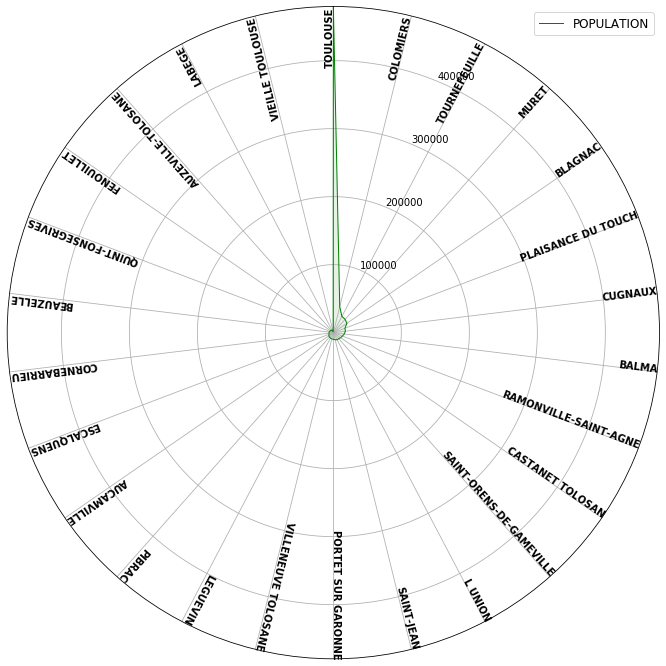

In [35]:
city_list = df2.City.unique()
val1      = df2[df2.ResidenceType == 'APARTMENT'].population.tolist()
plot_spider(city_list, val1, 'POPULATION',order=1)

we see that **<font color= green>Toulouse is by far the most populated city</font>** which also makes this graph not readable so now plot it without toulouse

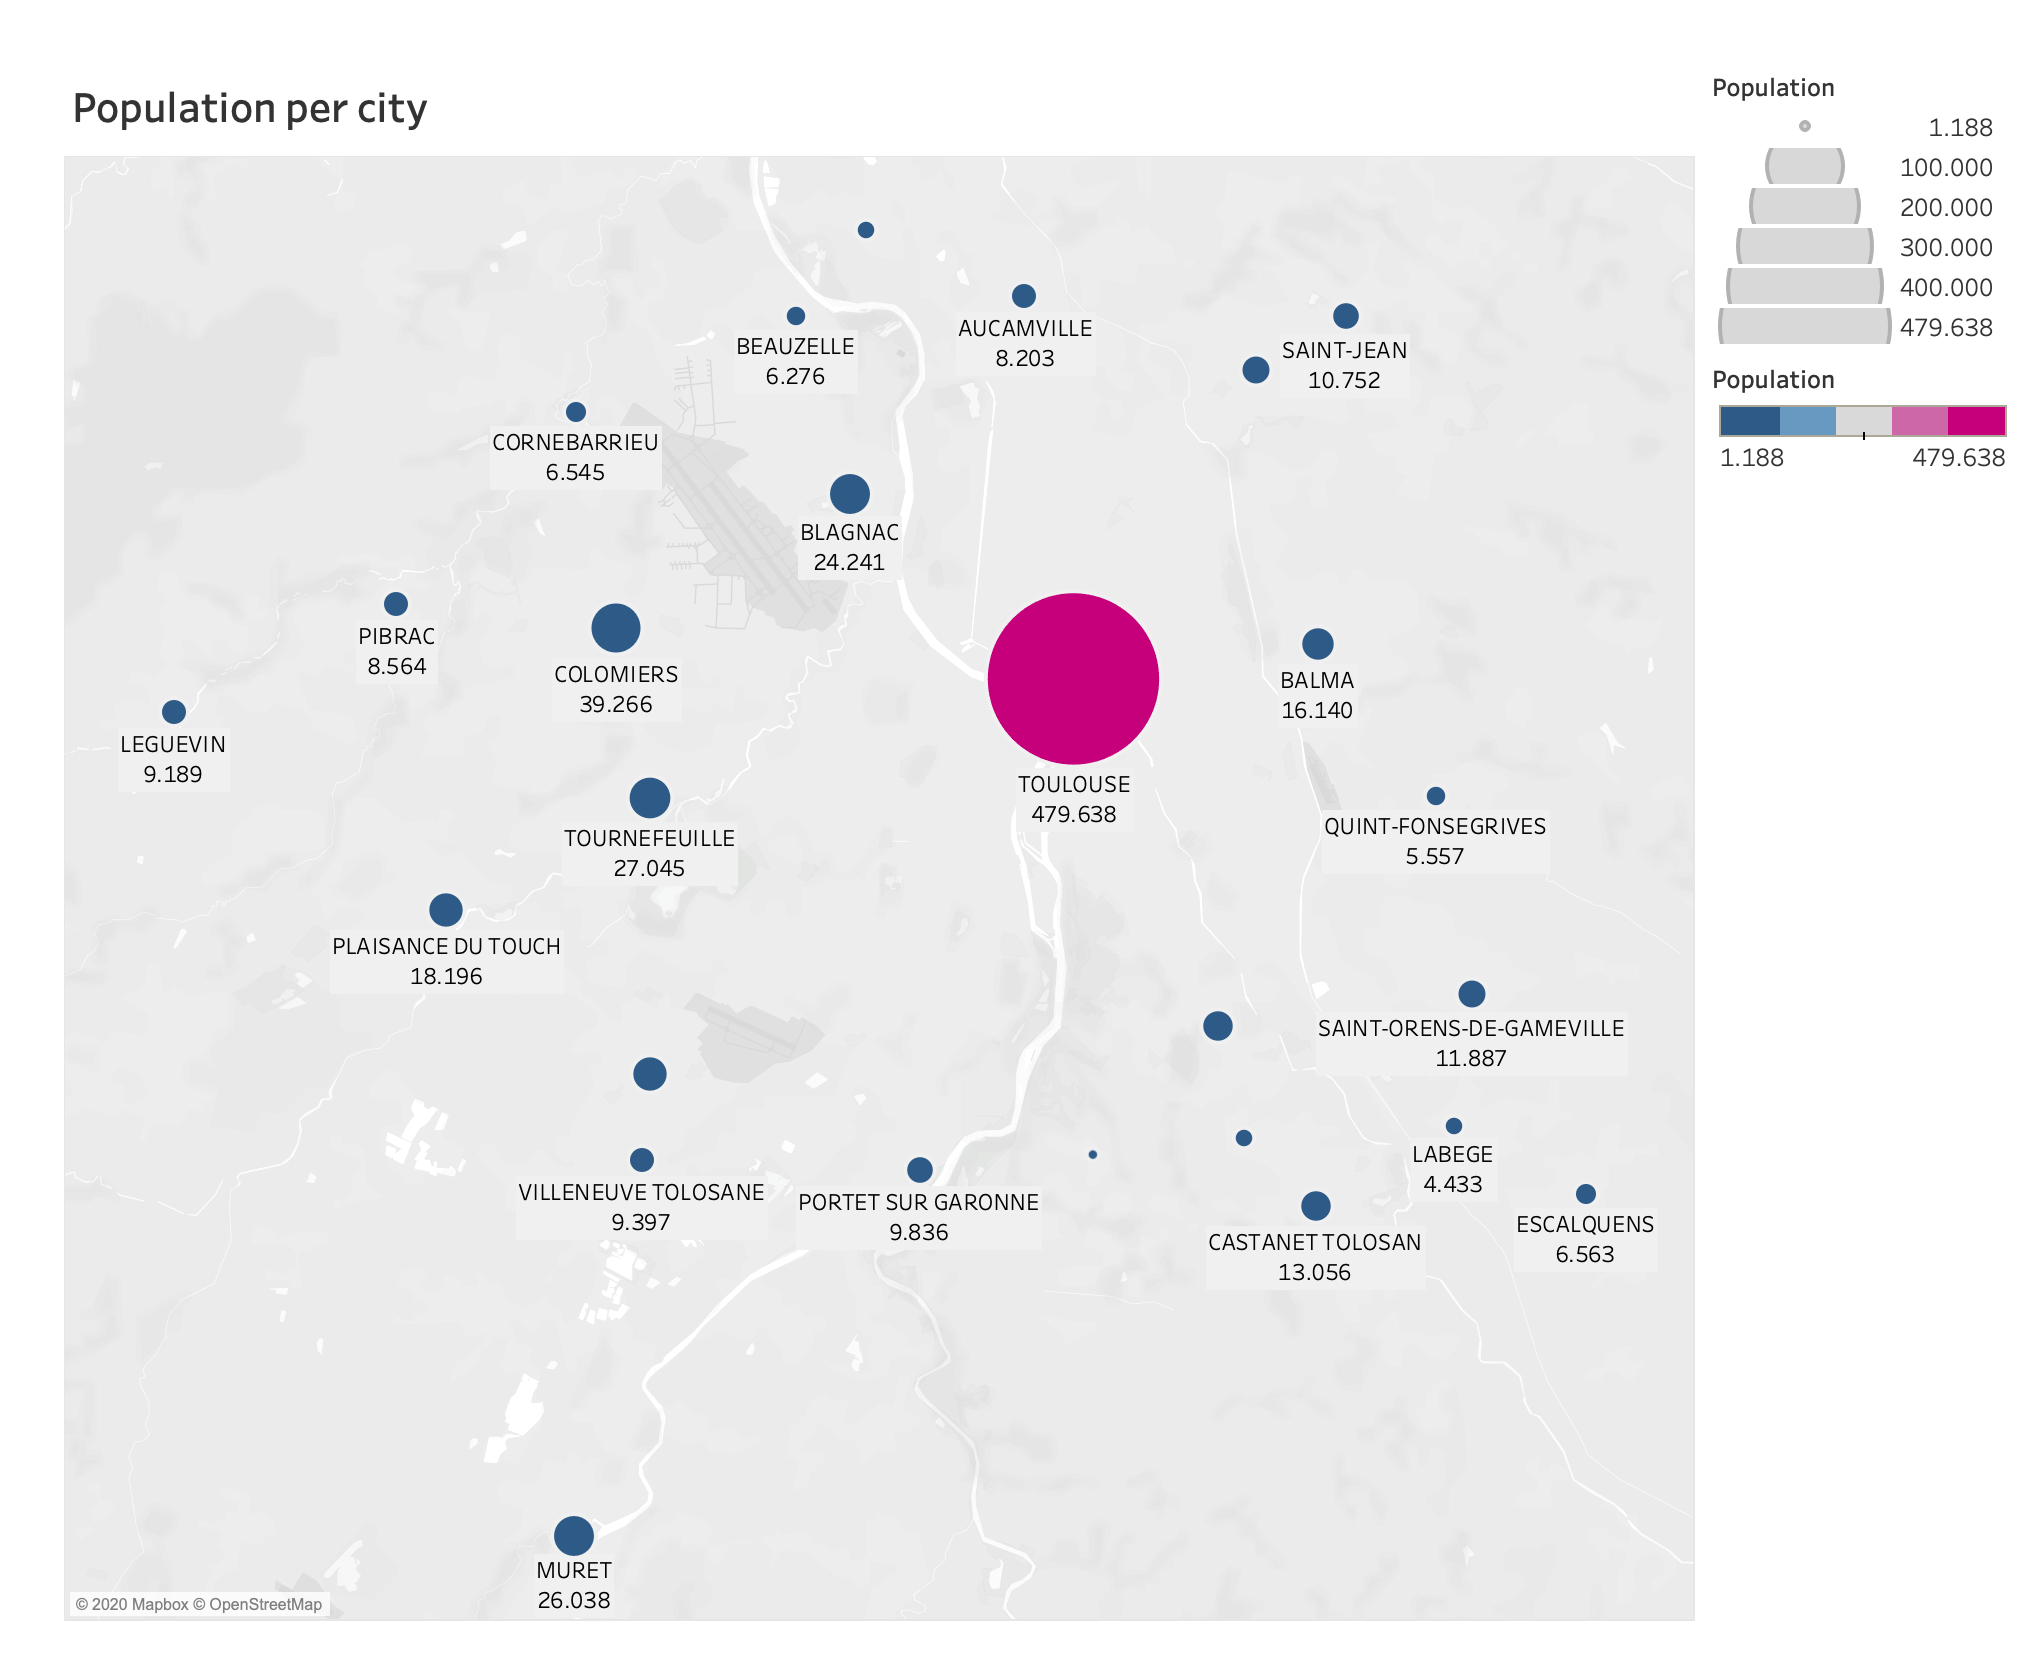

In [36]:
myImage2 = Image.open("population.png")
myImage2

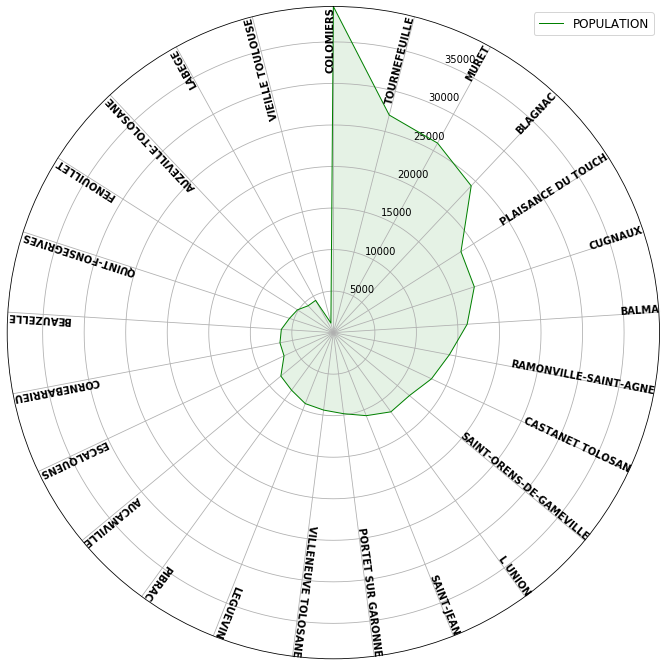

In [37]:
city_list = df2.City.unique()
ind = np.argwhere(city_list == "TOULOUSE")
city_list = np.delete(city_list,ind)
val1      = df2[df2.ResidenceType == 'APARTMENT'].population.tolist()
val1.pop(int(ind))

plot_spider(city_list, val1, 'POPULATION',order=1)

**<font color= green>we see a group of 4 populated cities with Colomiers, Tournefeuille, Muret, Blagnac from 40 to 25 thousand inhabitants <br>
Then comes plaisance du touch, cugnaux, balma in the 15-20 thousands range <br>
Then we see a progressive scale of population down to 1 thousand with Vieille Toulouse</font>**

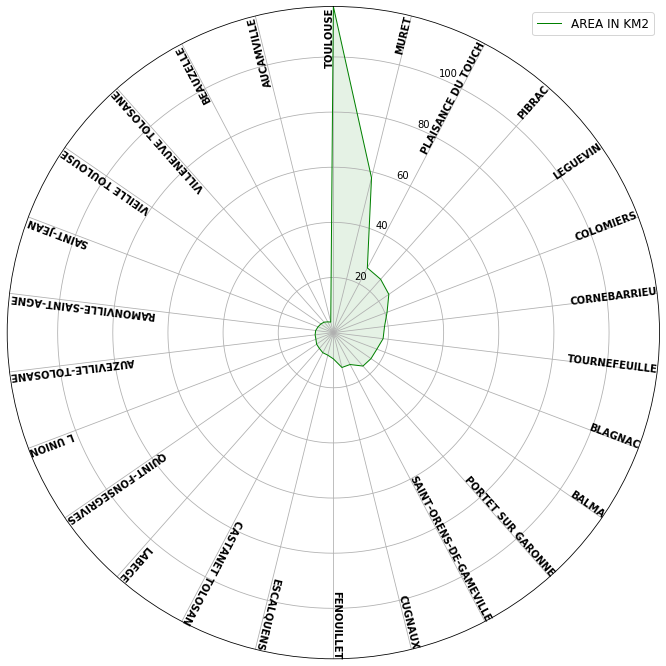

In [38]:
city_list = df2.City.unique()
val1      = df2[df2.ResidenceType == 'APARTMENT'].area_Km2.tolist()
plot_spider(city_list, val1, 'AREA IN KM2',order=1)

**<font color= green>In terms of area Toulouse obviously is the largest by far. Muret is also large. <br>
Plaisance, Pibrac and Leguevin appear larger than the others <br>
Then it progressively decreases</font>**

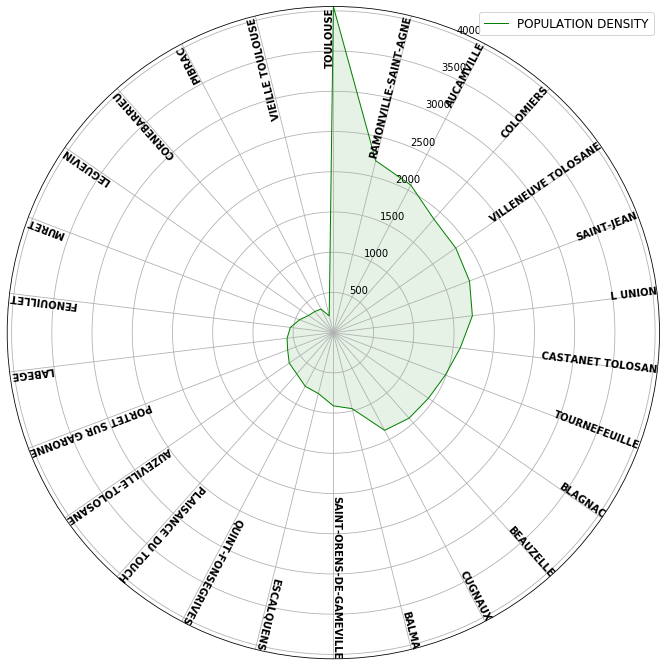

In [39]:
city_list = df2.City.unique()
val1      = df2[df2.ResidenceType == 'APARTMENT'].density.tolist()
plot_spider(city_list, val1, 'POPULATION DENSITY',order=1)

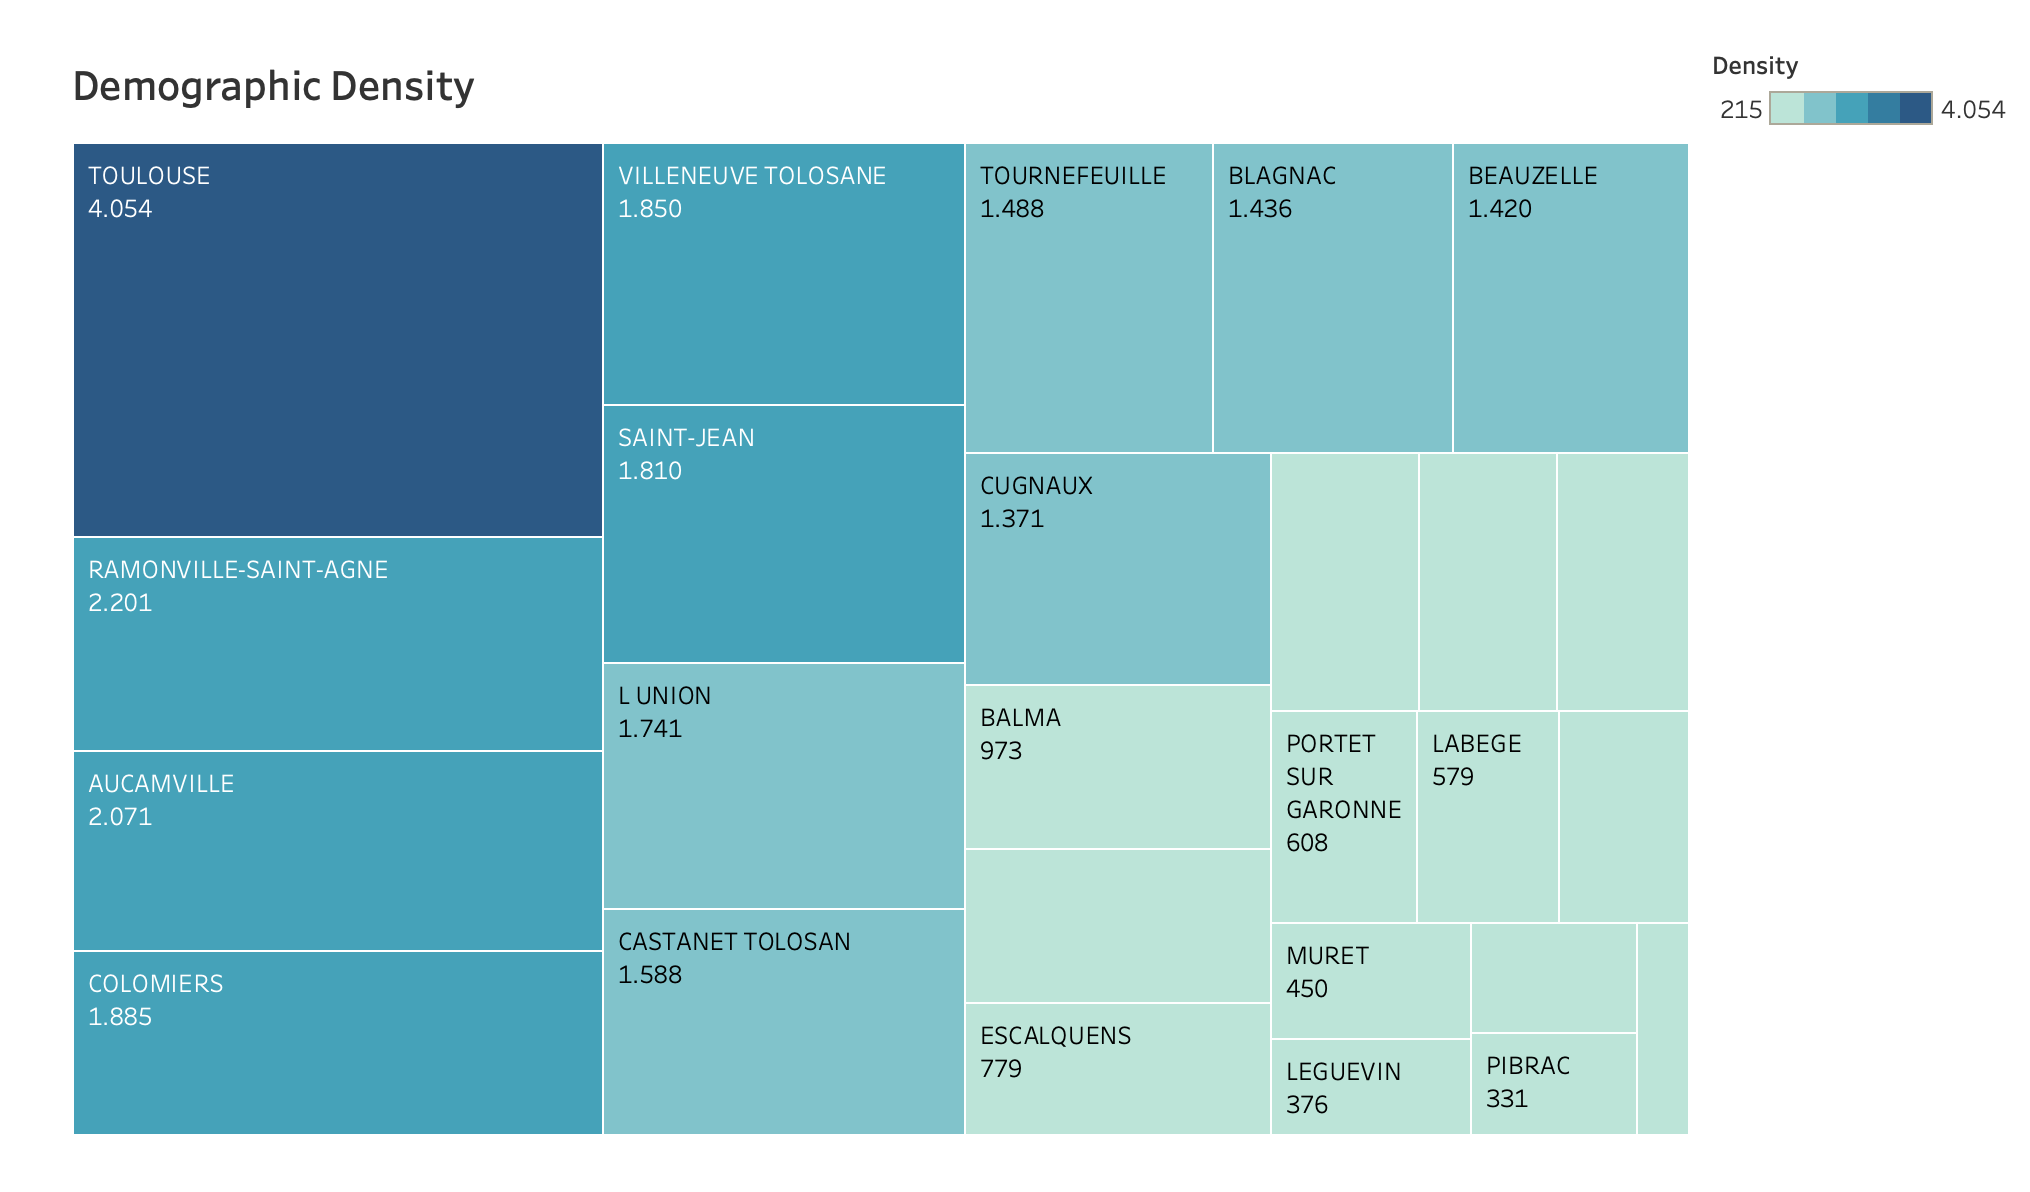

In [40]:
myImage3 = Image.open("density.png")
myImage3

**<font color= green>Population density is interesting when it comes to housing. With no surprise Toulouse is very dense
Then we see that Aucamville, Ramonville-saint-agne, l'Union, Saint-Jean, Villeneuve-Tolosane appear the most dense cities
On the opposite side, Vieille Toulouse appears with very low density</font>**

We'll look at the price. As already mentionned, quartiles are much more interpretable than mean so we'll **proceed with quartiles**

In [41]:
#unflatten quartile to get them in individual lists
flat_list = [item for sublist in list(df2["Q1_Q2_Q3 price"]) for item in sublist]
Q1_AP = flat_list[0::6]
Q2_AP = flat_list[1::6]
Q3_AP = flat_list[2::6]
Q1_HO = flat_list[3::6]
Q2_HO = flat_list[4::6]
Q3_HO = flat_list[5::6]


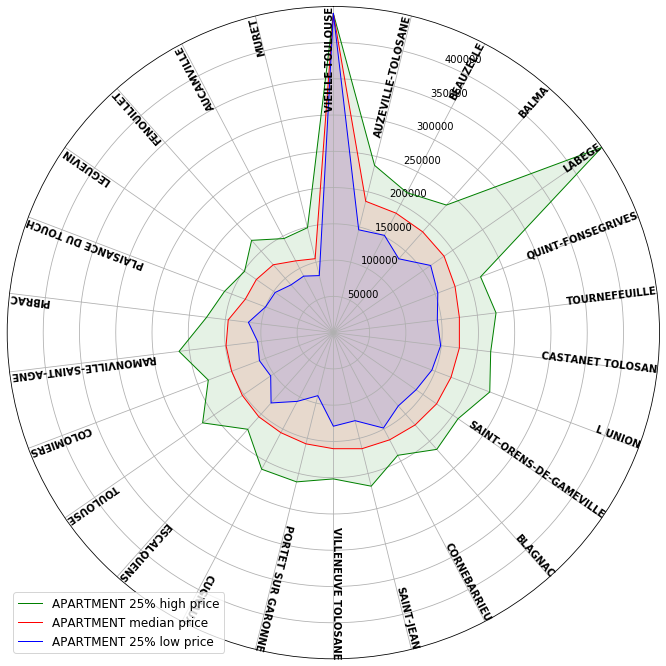

In [42]:
city_list = df2.City.unique()
val1      = Q3_AP
val2      = Q2_AP
val3      = Q1_AP
plot_spider(city_list, val1, 'APARTMENT 25% high price', val2, 'APARTMENT median price', val3, 'APARTMENT 25% low price', order=2)

**<font color= green>VIEILLE TOULOUSE and LABEGE clearly stands out for appartment sales <br>
VIEILLE TOULOUSE appear very high and very dense which might just mean than a handful of appartment were sold there <br>
For LABEGE it's the 3rd quartile that appears crazy, it might be that the high part is very expansive <br>
Let's look at those data points more closely</font>**

In [43]:
sale_df1.filter('City=="VIEILLE TOULOUSE"')\
                  .filter('ResidenceType=="APARTMENT"').show()

+-------------------+--------+--------+--------+----------------+-------+------+-------------+----------+--------+
|           SaleDate|SaleType|   Price|PostCode|            City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+-------------------+--------+--------+--------+----------------+-------+------+-------------+----------+--------+
|2016-03-25 00:00:00|    SALE|440000.0|   31320|VIEILLE TOULOUSE|      2|     0|    APARTMENT|        40|     500|
|2016-03-25 00:00:00|    SALE|440000.0|   31320|VIEILLE TOULOUSE|      2|     0|    APARTMENT|        40|    1240|
+-------------------+--------+--------+--------+----------------+-------+------+-------------+----------+--------+



**<font color= green>There were only 2 appartments sold in VIEILLE TOULOUSE, they also appear as duplicates since only the Land Area change. <br>
Clearly Apartment sales in VIEILLE TOULOUSE can be dismissed</font>**

In [44]:
N = sale_df1.filter('City=="LABEGE"')\
                  .filter('ResidenceType=="APARTMENT"').count()
print("there was ", N, "appartments sold in Labege")
sale_df1.filter('City=="LABEGE"')\
                  .filter('ResidenceType=="APARTMENT"').orderBy('Price', ascending=False).show(n=N)

there was  47 appartments sold in Labege
+-------------------+--------+--------+--------+------+-------+------+-------------+----------+--------+
|           SaleDate|SaleType|   Price|PostCode|  City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+-------------------+--------+--------+--------+------+-------+------+-------------+----------+--------+
|2016-12-14 00:00:00|    SALE|473650.0|   31670|LABEGE|      3|     0|    APARTMENT|        67|     250|
|2016-12-14 00:00:00|    SALE|473650.0|   31670|LABEGE|      2|     0|    APARTMENT|        38|     250|
|2016-12-14 00:00:00|    SALE|473650.0|   31670|LABEGE|      2|     0|    APARTMENT|        43|     250|
|2016-12-14 00:00:00|    SALE|473650.0|   31670|LABEGE|      2|     0|    APARTMENT|        51|     250|
|2016-12-14 00:00:00|    SALE|473650.0|   31670|LABEGE|      3|     0|    APARTMENT|        59|     250|
|2016-12-14 00:00:00|    SALE|473650.0|   31670|LABEGE|      2|     0|    APARTMENT|        42|     250|
|2016-11-29 00

**<font color= green>There appear to be few appartments sold in Labege overall. 2 collectives sales appear to be outstanding.
A sale of 6 appartments at 473650 euros Dec 14 2016, and a sale of 6 appartments at 449650 euros Nov 29 2016 <br>
Labege can also be dismissed to analyse the appartment sales</font>**

Redo the analyze dropping Vieille Toulouse and Labege since they make it harder to get a clear picture of the appartment market

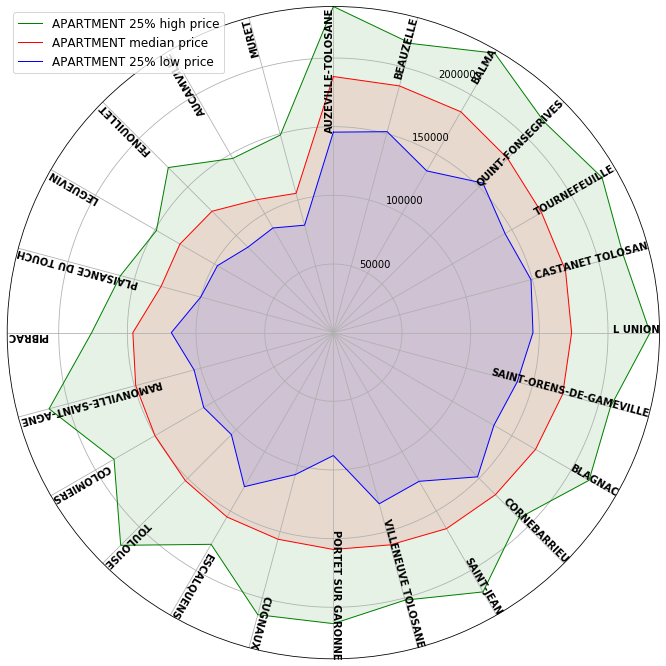

In [45]:
city_list = df2.City.unique()

# indices to remove
ind = np.concatenate( (np.argwhere(city_list == "VIEILLE TOULOUSE") ,np.argwhere(city_list == "LABEGE")) )

city_list = np.delete(city_list,ind)
val1      = [i for j, i in enumerate(Q3_AP) if j not in ind]
val2      = [i for j, i in enumerate(Q2_AP) if j not in ind]
val3      = [i for j, i in enumerate(Q1_AP) if j not in ind]

plot_spider(city_list, val1, 'APARTMENT 25% high price', val2, 'APARTMENT median price', val3, 'APARTMENT 25% low price', order=2)


**<font color= green>The appartment market appears stretched considering the least and most expensive :</font>**
* **<font color= green>The median apparment price goes from 105k in MURET to 186.5k in AUZEVILLE-TOLOSANE</font>**
* **<font color= green>The high Tear segment (above 25% most expensive sales) go from 146.5k in AUCAMVILLE to 237.5k in AUZEVILLE-TOLOSANE</font>**
* **<font color= green>The low Tear segment (below 25% least expensive sales) go from 81k in MURET to 154k in QUINT-FONSEGRIVES</font>**




In [46]:
print("lower median price is" ,min(val2)/1e3, "in",city_list[np.argmin(np.array(val2))]) 
print("higher median price is" ,max(val2)/1e3, "in",city_list[np.argmax(np.array(val2))]) 
print("\n")

print("lower Q3 price is" ,min(val1)/1e3, "in",city_list[np.argmin(np.array(val1))]) 
print("higher Q3 price is" ,max(val1)/1e3, "in",city_list[np.argmax(np.array(val1))]) 
print("\n")

print("lower Q1 price is" ,min(val3)/1e3, "in",city_list[np.argmin(np.array(val3))]) 
print("higher Q1 price is" ,max(val3)/1e3, "in",city_list[np.argmax(np.array(val3))]) 



lower median price is 105.0 in MURET
higher median price is 186.5 in AUZEVILLE-TOLOSANE


lower Q3 price is 146.5 in AUCAMVILLE
higher Q3 price is 237.5 in AUZEVILLE-TOLOSANE


lower Q1 price is 81.0 in MURET
higher Q1 price is 154.0 in QUINT-FONSEGRIVES


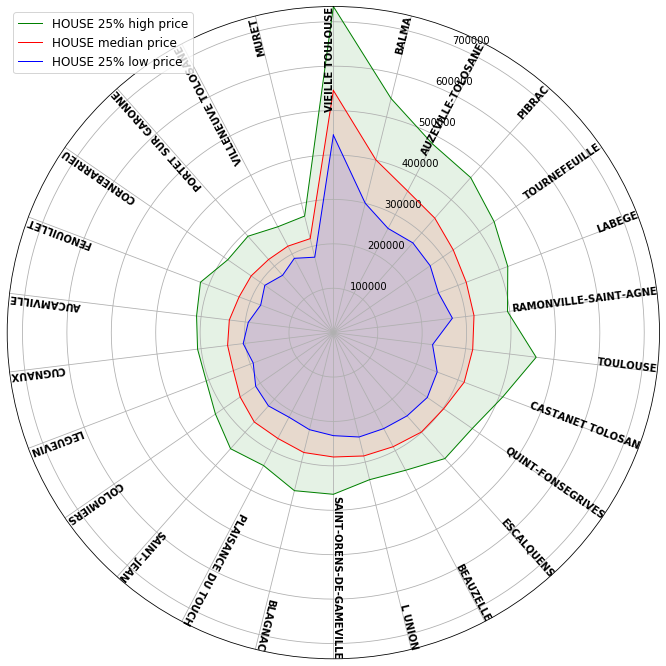

In [47]:
city_list = df2.City.unique()
val1      = Q3_HO
val2      = Q2_HO
val3      = Q1_HO
plot_spider(city_list, val1, 'HOUSE 25% high price', val2, 'HOUSE median price', val3, 'HOUSE 25% low price', order=2)

**<font color= green>VIEILLE TOULOUSE is by far the most expansice place for house sales. It has the higher median, lower 25% and higher 25% prices <br>
MURET is where in general the cheapest properties can be found with a median price of 218k <br>
VILLENEUVE TOLOSANE is the most reasonable market with a 25% most expansive sales of 269k <br>
PORTET SUR GARONNE is where the cheapest sales can be found with a 25% least expansive sales of 172.5k</font>**


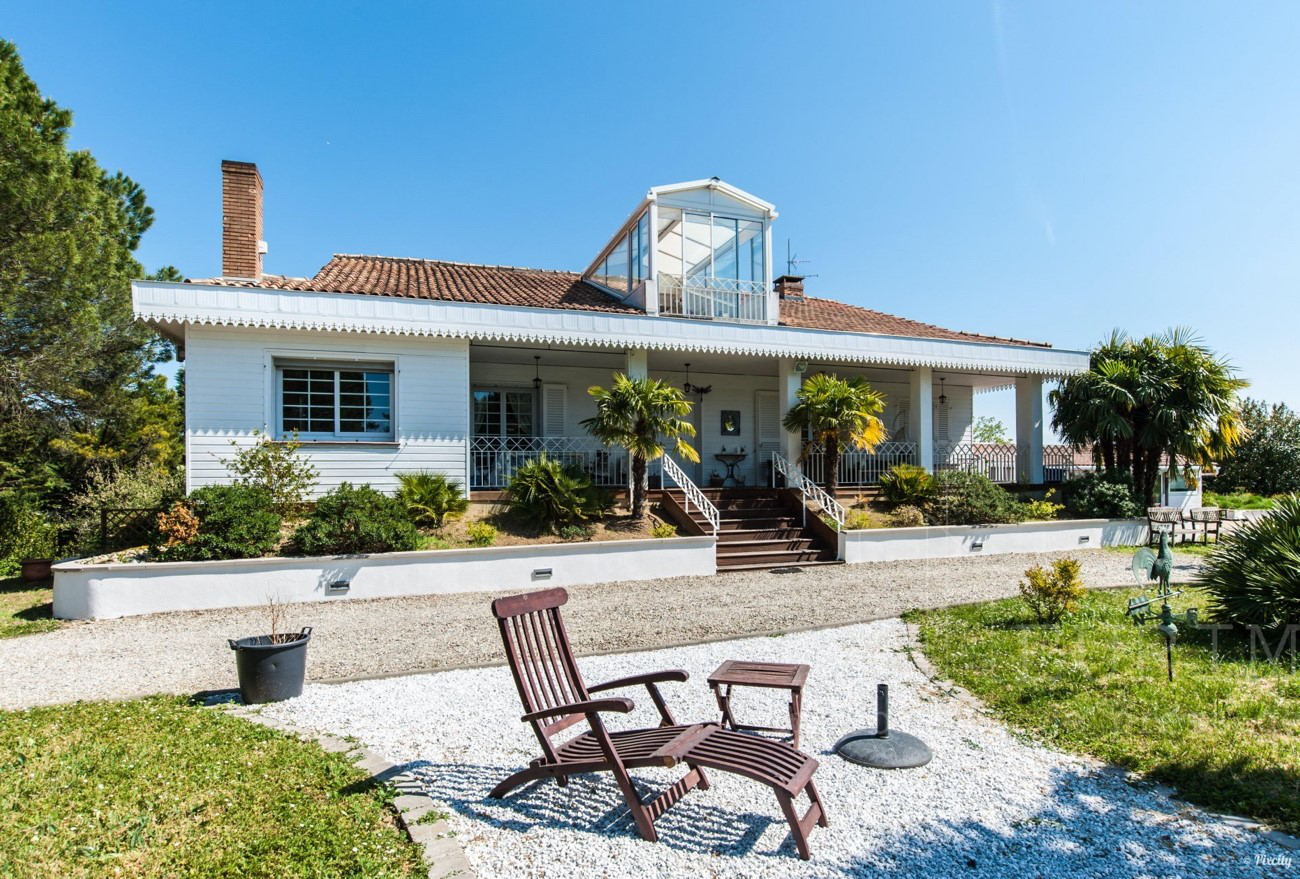

In [48]:
myImage1 = Image.open("vieilletoulouse.jpg")
myImage1

The image above can represent the standard residence in Vieille Toulouse.

In [49]:
print("lower median price is" ,min(val2)/1e3, "in",city_list[np.argmin(np.array(val2))]) 
print("higher median price is" ,max(val2)/1e3, "in",city_list[np.argmax(np.array(val2))]) 
print("\n")

print("lower Q3 price is" ,min(val1)/1e3, "in",city_list[np.argmin(np.array(val1))]) 
print("higher Q3 price is" ,max(val1)/1e3, "in",city_list[np.argmax(np.array(val1))]) 
print("\n")

print("lower Q1 price is" ,min(val3)/1e3, "in",city_list[np.argmin(np.array(val3))]) 
print("higher Q1 price is" ,max(val3)/1e3, "in",city_list[np.argmax(np.array(val3))]) 

 


lower median price is 218.0 in MURET
higher median price is 545.5 in VIEILLE TOULOUSE


lower Q3 price is 269.2 in VILLENEUVE TOLOSANE
higher Q3 price is 734.4 in VIEILLE TOULOUSE


lower Q1 price is 172.5 in PORTET SUR GARONNE
higher Q1 price is 444.8 in VIEILLE TOULOUSE


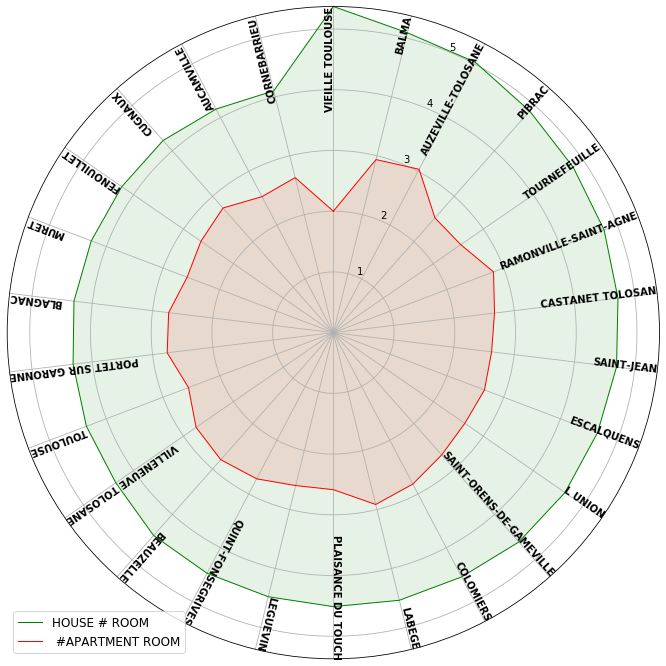

In [50]:
city_list = df2.City.unique()
val1      = df2[df2.ResidenceType == 'HOUSE'].mean_NbRooms.tolist()
val2      = df2[df2.ResidenceType == 'APARTMENT'].mean_NbRooms.tolist()
plot_spider(city_list, val1, 'HOUSE # ROOM', val2, ' #APARTMENT ROOM',order=1)

**<font color= green>The number of rooms in house kind of follow the price order with VIEILLE TOULOUSE, BALMA, AUZEVILLE-TOLOSANE, PIBRAC, TOURNEFEUILLE leading the path <br>
But the difference is not huge but rather progressive <br>
The number of rooms in appartments is more or less following the number of rooms in houses with some slight differences since the curve is not fully a spiral but has a bit of hollows and bumps</font>**

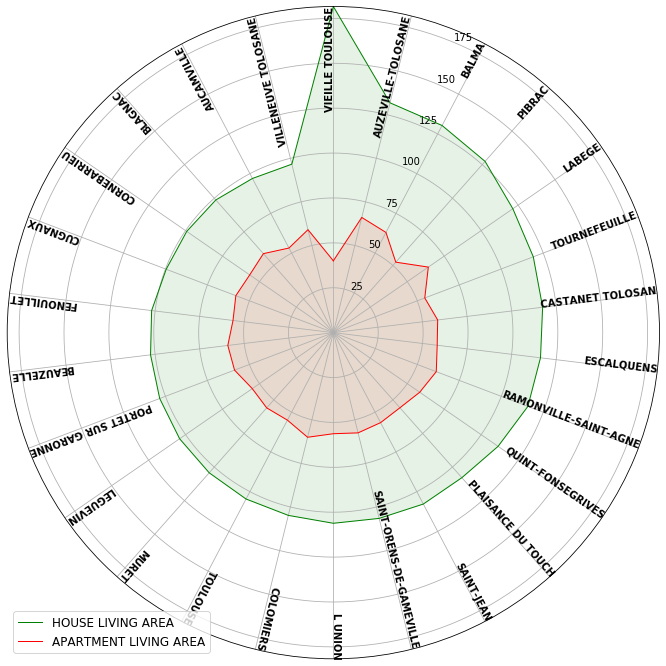

In [51]:
city_list = df2.City.unique()
val1      = df2[df2.ResidenceType == 'HOUSE'].LivingArea.tolist()
val2      = df2[df2.ResidenceType == 'APARTMENT'].LivingArea.tolist()
plot_spider(city_list, val1, 'HOUSE LIVING AREA', val2, 'APARTMENT LIVING AREA',order=1)

**<font color= green>Same pattern applies for land area as for number of rooms. <br>
The only outstanding differences is that VIEILLE TOULOUSE is spiking here</font>**

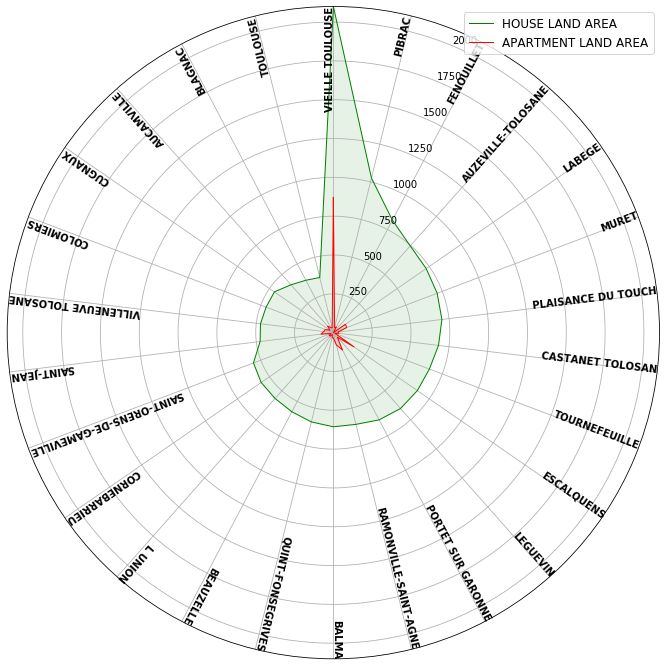

In [52]:
city_list = df2.City.unique()
val1      = df2[df2.ResidenceType == 'HOUSE'].LandArea.tolist()
val2      = df2[df2.ResidenceType == 'APARTMENT'].LandArea.tolist()
plot_spider(city_list, val1, 'HOUSE LAND AREA', val2, 'APARTMENT LAND AREA', order=1)

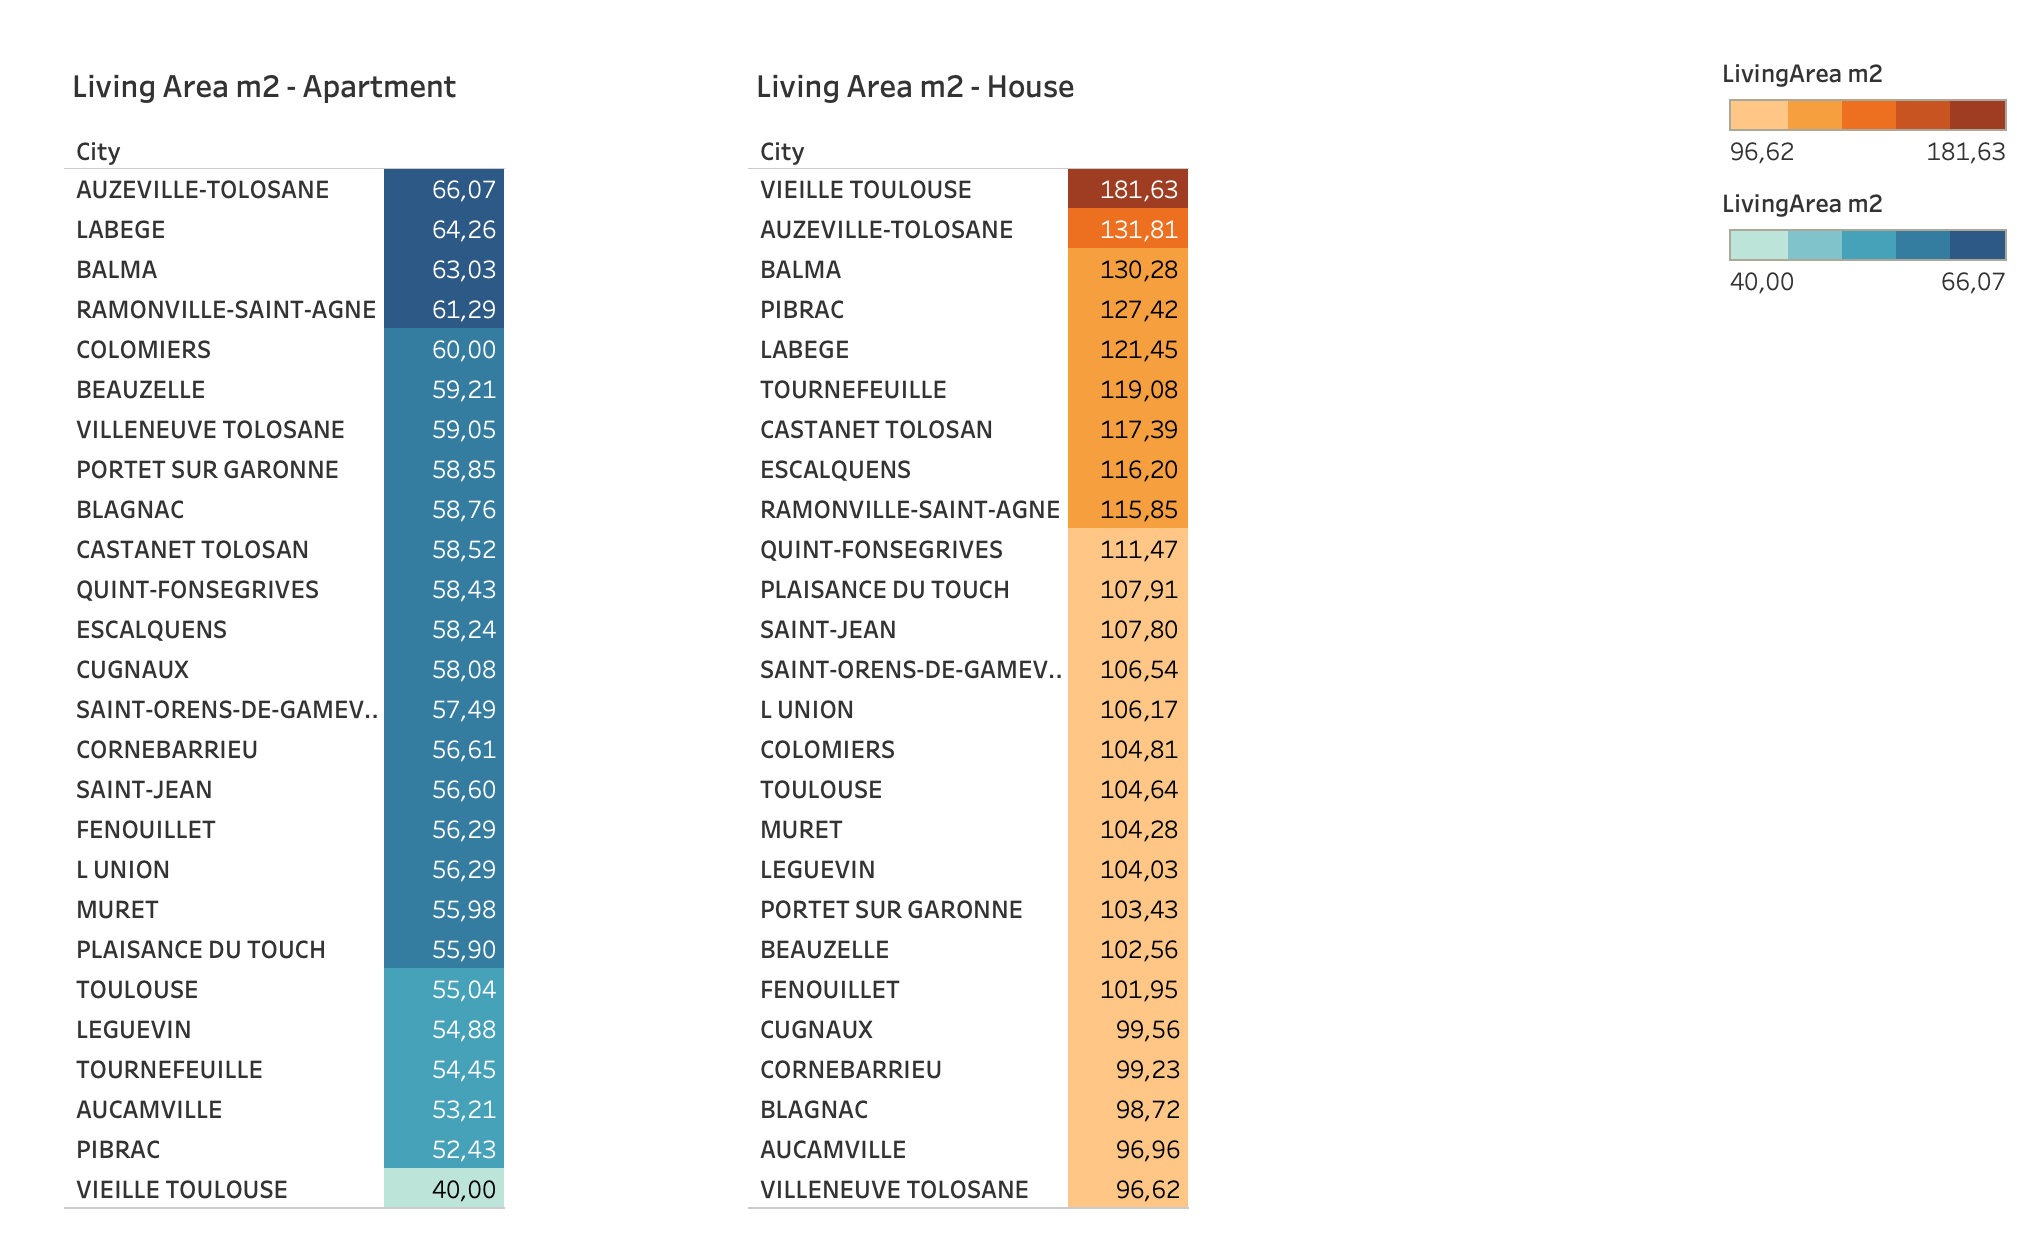

In [53]:
myImage4 = Image.open("living.png")
myImage4

**<font color= green>When it comes to land area, VIEILLE TOULOUSE is massively ahead with an average land area above 2000m2 <br>
Other data come invisible so need to take VIEILLE TOULOUSE out</font>**

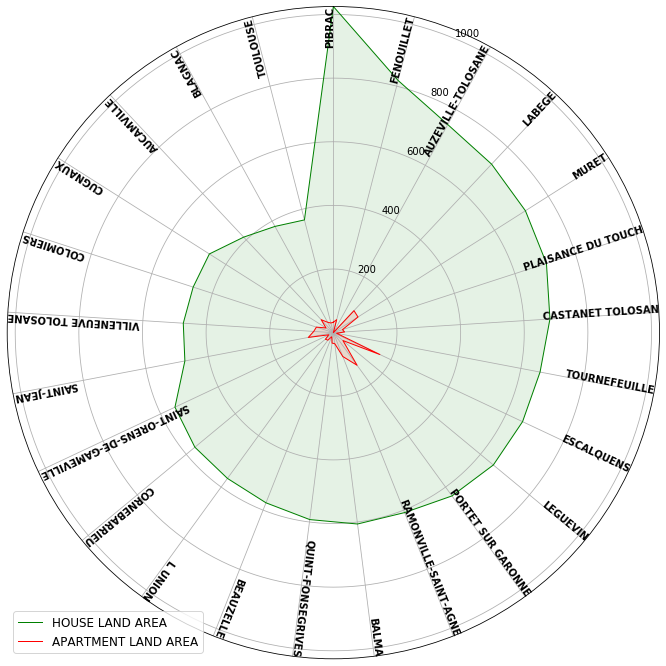

In [54]:
city_list = df2.City.unique()
ind = np.argwhere(city_list == "VIEILLE TOULOUSE")
city_list = np.delete(city_list,ind)

val1      = df2[df2.ResidenceType == 'HOUSE'].LandArea.tolist()
val2      = df2[df2.ResidenceType == 'APARTMENT'].LandArea.tolist()
val1.pop(int(ind))
val2.pop(int(ind))

plot_spider(city_list, val1, 'HOUSE LAND AREA', val2, 'APARTMENT LAND AREA', order=1)

**<font color= green>Significant differences (1000m2 to 400m2) in land area still remain <br>
It also appears that in some cities like LABEGE, MURET, ESCALQUENS, PORTET-SUR-GARONNE appartments can come with land bigger than elsewhere</font>**

# Evolution analysis

here we want to see how the situation evolves year over year in each city

In [55]:
# add columns Year and Month
split_col = pyspark.sql.functions.split(sale_df1['SaleDate'], '-')
sale_df1  = sale_df1.withColumn('Year', split_col.getItem(0))
sale_df1  = sale_df1.withColumn('Month', split_col.getItem(1))
sale_df1  = sale_df1.withColumn("euro_per_m2", (F.col("Price") / F.col("LivingArea")))

In [56]:
#price_pd_df      = sale_df1.groupBy('City','ResidenceType').agg({'price':'avg'}).withColumnRenamed('avg(price)','mean_price').orderBy(['City','ResidenceType'], ascending=[True, True]).toPandas()
price_pd_df      = sale_df1.groupBy('City','Year').agg({'euro_per_m2':'avg'}).withColumnRenamed('avg(euro_per_m2)','euro_per_m2').orderBy(['City','Year'], ascending=[True, True]).toPandas()
price_pd_df

City  Year  euro_per_m2
0             AUCAMVILLE  2015  2663.985746
1             AUCAMVILLE  2016  3322.417819
2             AUCAMVILLE  2017  2514.041226
3             AUCAMVILLE  2018  2762.177392
4             AUCAMVILLE  2019  2468.416938
..                   ...   ...          ...
125  VILLENEUVE TOLOSANE  2015  2860.268306
126  VILLENEUVE TOLOSANE  2016  3552.208407
127  VILLENEUVE TOLOSANE  2017  3295.242126
128  VILLENEUVE TOLOSANE  2018  2647.431504
129  VILLENEUVE TOLOSANE  2019  2543.116579

[130 rows x 3 columns]

In [57]:
# compute year over year growth
price_pd_df['price_growth']=100*price_pd_df['euro_per_m2'].diff()/price_pd_df['euro_per_m2']
price_pd_df = price_pd_df[price_pd_df.Year != '2015']

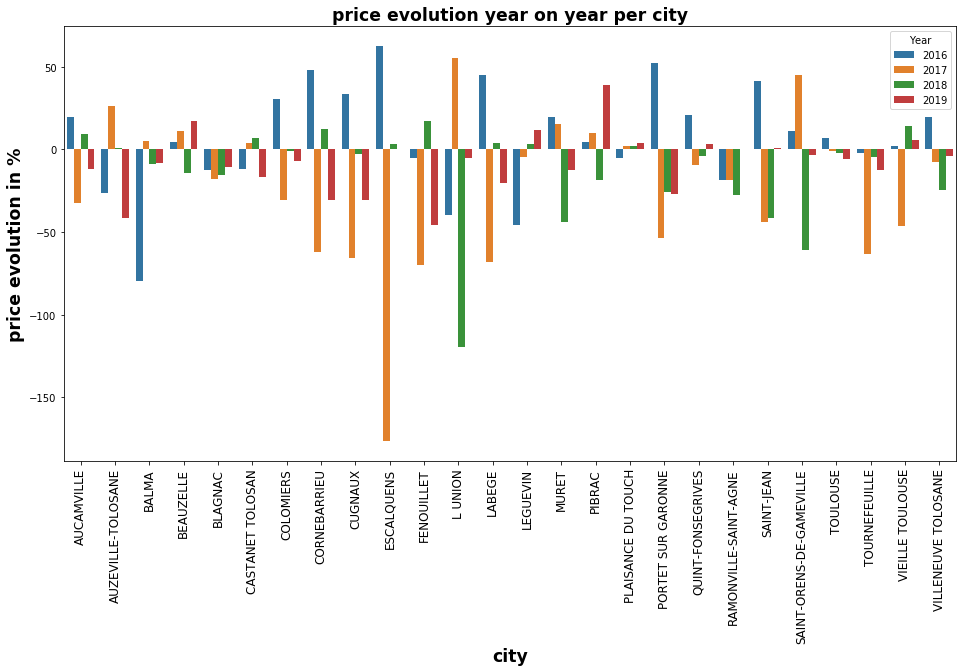

In [58]:
plt.figure( figsize = (16, 8) )
chart=sb.barplot(data=price_pd_df, x='City', hue='Year', y='price_growth', ci=None)
chart.set_title('price evolution year on year per city',fontsize='xx-large',fontweight='bold')
chart.set_xlabel('city',fontsize='xx-large',fontweight='bold')
chart.set_ylabel('price evolution in %',fontsize='xx-large',fontweight='bold')
chart.set_xticklabels(
                        chart.get_xticklabels(), 
                        rotation=90, 
                        horizontalalignment='center',
                        verticalalignment='top',  
                        fontweight='light',
                        fontsize='large',
                    )
plt.show()
#'center' | 'top' | 'bottom' | 'baseline'

**<font color= green>Price evolution is very diverse per city and per year <br>
For instance in 2017 prices decreased a lot in some cities e.g. ESCALQUENS, CORNEBARIEU, CUGNAUX but increased a lot in L'UNION or SAINT-ORENS <br>
Similar discrepencies is visible for 2019</font>**

# Maps 

here we want to show a map of prices

## Per city median price

In [59]:
# import geojson file collected from http://toulouse-dataviz.fr/hackaviz-2019-telechargement-donnees
geo = gpd.read_file('par_commune.geojson')

NameError: name 'gpd' is not defined

In [ ]:
# remove unnecessary columns
geo1 = geo.drop(['ID_GEOFLA', 'INSEE_COM', 'departement', 'altitude_moy', 'statut', 'departement_nom',
       'emplois', 'menages', 'pers_par_menages',
       'unite_conso_menages', 'revenu_median', '2015_1', '2015_inter_voiture',
       '2015_extra_voiture', '2015_sansvoiture', '2015_extra_csp1',
       '2015_extra_csp2', '2015_extra_csp3', '2015_inter_csp1',
       '2015_inter_csp2', '2015_inter_csp3', '2009_inter', '2009_extra',
       '2009_1', '2009_extra_communes', '2009_intra_communes', '2009_extra_km',
       '2009_intra_km', '2009_extra_heure', '2009_intra_heure', '2014_inter',
       '2014_extra', '2014_1', '2014_extra_communes', '2014_intra_communes',
       '2014_extra_km', '2014_intra_km', '2014_extra_heure',
       '2014_intra_heure'], axis=1)

In [ ]:
# keep only cities of interest. becareful of the writing convention between files
geo2=geo1 [ geo1.commune.isin(['AUCAMVILLE', 'AUZEVILLE TOLOSANE', 'BALMA', 'BEAUZELLE',
       'BLAGNAC', 'CASTANET TOLOSAN', 'COLOMIERS', 'CORNEBARRIEU',
       'CUGNAUX', 'ESCALQUENS', 'FENOUILLET', "L'UNION", 'LABEGE',
       'LEGUEVIN', 'MURET', 'PIBRAC', 'PLAISANCE DU TOUCH',
       'PORTET SUR GARONNE', 'QUINT FONSEGRIVES', 'RAMONVILLE SAINT AGNE',
       'SAINT JEAN', 'SAINT ORENS DE GAMEVILLE', 'TOULOUSE',
       'TOURNEFEUILLE', 'VIEILLE TOULOUSE', 'VILLENEUVE TOLOSANE']) ].reset_index().drop('index',axis=1)
#len(geo2)

In [ ]:
geo2= geo2.sort_values(by ='commune' , ascending=True).reset_index().drop(columns='index')
#geo2

In [ ]:
# FENOUILLET & AUCAMVILLE were twice, remove wrong duplicates
geo2.drop(index=[1,11], inplace=True)
geo2= geo2.reset_index().drop(columns='index')
#geo2

In [ ]:
# add cities with consistent naming
geo2['City']=df2.City.unique()
#geo2

In [ ]:
#remove duplicated columns 
geo2 = geo2.drop(columns='commune')
#geo2

In [ ]:
# add house median prices
geo2['median price']=Q2_HO

In [ ]:
#ax=plt.figure( figsize = (16, 8) )
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
geo2.plot(column='median price',
          ax=ax,
          legend=True,
          legend_kwds={'label': "Price in euro",
                       'orientation': "horizontal"})

for idx, row in geo2.iterrows():
    if row['City'] == 'PORTET SUR GARONNE':
        plt.annotate(s=row['City'], xy=(row['latitude'],row['longitude']+0.01),
                     horizontalalignment='center')
    elif row['City'] == 'VILLENEUVE TOLOSANE':
        plt.annotate(s=row['City'], xy=(row['latitude'],row['longitude']-0.007),
                     horizontalalignment='center')
    elif row['City'] == 'VIEILLE TOULOUSE':
        plt.annotate(s=row['City'], xy=(row['latitude'],row['longitude']-0.007),
                     horizontalalignment='center')
    else:
        plt.annotate(s=row['City'], xy=(row['latitude'],row['longitude']),
                     horizontalalignment='center')

ax.set_xlabel('latitude',Fontweight='light',fontsize=14)             # add x-axis label
ax.set_ylabel('longitude ',Fontweight='light',FontSize=14)                   # add y-axis label
ax.set_title('House Median Price Per City',Fontweight='bold',FontSize=20)        # add title
       

**<font color= green>As already seen, Vieille prices stand out <br>
It also appears that west is less expensive than east, especially south-west and north-west are the least expansive places</font>**

## Average Price inside Toulouse

Next we want to have a closer look at Toulouse and see price per post code

In [60]:
price2_pd_df = sale_df1.filter('City=="TOULOUSE"')\
                       .groupBy('PostCode','ResidenceType')\
                       .agg({'price':'avg'})\
                       .withColumnRenamed('avg(price)','mean_price')\
                       .orderBy(['PostCode','ResidenceType'], ascending=[True, True])\
                       .toPandas()
price2_pd_df

PostCode ResidenceType     mean_price
0      31000     APARTMENT  316516.358494
1      31000         HOUSE  582363.446509
2      31100     APARTMENT  286862.899909
3      31100         HOUSE  301459.546588
4      31200     APARTMENT  207714.349483
5      31200         HOUSE  387290.757492
6      31300     APARTMENT  215546.703557
7      31300         HOUSE  394229.953415
8      31400     APARTMENT  200510.027617
9      31400         HOUSE  489045.228033
10     31500     APARTMENT  198284.634417
11     31500         HOUSE  427801.425363

In [61]:
tls = gpd.read_file('codes-postaux-de-toulouse.geojson')

NameError: name 'gpd' is not defined

In [ ]:
tls.rename(columns={
    'code_postal' : 'PostCode'
},inplace='TRUE')

In [ ]:
tls.PostCode = pd.to_numeric(tls.PostCode)

In [ ]:
tls = tls[tls.PostCode.isin([31000, 31100, 31200, 31300, 31400, 31500])].sort_values(by=['PostCode'])

In [ ]:
price2_pd_df = price2_pd_df[price2_pd_df.PostCode.isin([31000, 31100, 31200, 31300, 31400, 31500])].sort_values(by=['PostCode'])

In [ ]:
tls['mean_price'] = list(price2_pd_df[price2_pd_df.ResidenceType == 'HOUSE'].mean_price)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
tls.plot(column='mean_price',
          ax=ax,
          legend=True,
          legend_kwds={'label': "price in euros",
                       'orientation': "horizontal"})

ax.set_xlabel('latitude',Fontweight='light',fontsize=14)             # add x-axis label
ax.set_ylabel('longitude ',Fontweight='light',FontSize=14)                   # add y-axis label
ax.set_title('Average house price per post code area in Toulouse City',Fontweight='bold',FontSize=20)        # add title

**<font color= green>The city center is obviously the most expensive area for house. <br>
    Then followed the south east, the south west is least expensive place to live.
So it appears that Toulouse city geographical price distribution is similar to greater Toulouse </font>**

In [ ]:
tls['mean_price'] = list(price2_pd_df[price2_pd_df.ResidenceType == 'APARTMENT'].mean_price)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
tls.plot(column='mean_price',
          ax=ax,
          legend=True,
          legend_kwds={'label': "price in euros",
                       'orientation': "horizontal"})

ax.set_xlabel('latitude',Fontweight='light',fontsize=14)             # add x-axis label
ax.set_ylabel('longitude ',Fontweight='light',FontSize=14)                   # add y-axis label
ax.set_title('Average apartment price per post code area in Toulouse City',Fontweight='bold',FontSize=20)        # add title

**<font color= green>The city center is again and not surprisingly the most expensive area for apartments. <br>
But then the distribution is quite different that the one for houses and almost reversed with the south west being the most expensive area cycling clockwise to the south east. </font>**